In [1000]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import datetime as dt
%matplotlib inline
from sklearn.cluster import KMeans

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [1001]:
# Reading csv file
ecom = pd.read_csv('ConsumerElectronics.csv',na_values=['\\N',''])
ecom.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,NaN,NaN,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,NaN,NaN,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,NaN,NaN,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,NaN,NaN,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,NaN,NaN,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [1002]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      335852 non-null float64
deliverycdays                      335853 non-null float64
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null object
prod

In [1003]:
ecom=ecom.rename({"gmv":"GMV","units":"Units","s1_fact.order_payment_type":"OrderPaymentType","sla":"SLA","deliverycdays":"DeliveryCDays","cust_id":"CustomerId"},axis=1)
ecom=ecom.rename({"product_analytic_vertical":"ProductVertical","product_mrp":"MRP","product_procurement_sla":"ProcurementSLA"},axis=1)
ecom=ecom.rename({"order_item_id":"OrderItemId","pincode":"Pincode","product_analytic_super_category":"ProductSuperCategory","product_analytic_category":"ProductCategory"},axis=1)
ecom=ecom.rename({"fsn_id":"FSNID","order_date":"OrderDate","order_id":"OrderId","product_analytic_sub_category":"ProductSubCategory","deliverybdays":"DeliveryBDay"},axis=1)

In [1004]:
# Changing datatype as per data behavoiur  

ecom['OrderDate']= pd.to_datetime(ecom['OrderDate'])  # Converting Order date from string to Date format
ecom['OrderId']= ecom['OrderId'].astype(str) # Converting Order_id/OrderItemId from float to String
ecom['OrderItemId']= ecom['OrderItemId'].astype(str)

In [1005]:
# Changing datatype of the columns
ecom["GMV"]=pd.to_numeric(ecom.GMV, errors='coerce')
ecom["DeliveryBDay"]=pd.to_numeric(ecom.DeliveryBDay, errors='coerce')
ecom["DeliveryCDays"]=pd.to_numeric(ecom.DeliveryCDays, errors='coerce')
ecom["CustomerId"]=pd.to_numeric(ecom.CustomerId, errors='coerce')
ecom["Pincode"]=pd.to_numeric(ecom.Pincode, errors='coerce')

In [1006]:
ecom.shape

(1648824, 20)

In [1007]:
#Filtering the data
ecom=ecom.loc[(ecom['OrderDate']>='2015-07-01 00:00:00') & (ecom['OrderDate']<'2016-07-01 23:59:59'),:]
ecom.shape

(1648330, 20)

In [1008]:
#Examining the columns
round(100*(ecom.isnull().sum()/len(ecom.index)),2)

FSNID                    0.00
OrderDate                0.00
Year                     0.00
Month                    0.00
OrderId                  0.00
OrderItemId              0.00
GMV                      0.30
Units                    0.00
DeliveryBDay            79.65
DeliveryCDays           79.65
OrderPaymentType         0.00
SLA                      0.00
CustomerId               0.30
Pincode                  0.30
ProductSuperCategory     0.00
ProductCategory          0.00
ProductSubCategory       0.00
ProductVertical          0.35
MRP                      0.00
ProcurementSLA           0.00
dtype: float64

In [1009]:
ecom['Week']=pd.DatetimeIndex(data=ecom['OrderDate']).week

In [1010]:
#Jan 2016 should be the 54th week.. Hence updateing the weeks
ecom.loc[(ecom['Year'] == 2016) & (ecom['Week']<=26),'Week'] = ecom['Week']+53
ecom['Week'].unique()

array([42, 43, 41, 44, 40, 45, 46, 69, 63, 39, 61, 70, 58, 48, 47, 38, 60,
       56, 67, 55, 57, 64, 59, 66, 62, 49, 35, 54, 65, 53, 71, 50, 51, 52,
       68, 76, 74, 72, 73, 75, 79, 77, 78, 29, 30, 28, 31, 37, 27, 32, 34,
       33, 36], dtype=int64)

In [1011]:
# dropping NaN rows where GMV=NULL which is .3%
ecom.dropna(subset=['GMV'], how='all', inplace = True)
print(ecom.shape)

(1643426, 21)


In [1012]:
# Dropping duplicates for combination of [FSN ID,OrderDate,OrderId,OrderItemId&Units]
ecom.drop_duplicates(subset =['FSNID','OrderDate','OrderId','OrderItemId','Units','CustomerId'],keep = False, inplace = True) 
print(ecom.shape)

(1435236, 21)


In [1013]:
#Removing free products
ecom=ecom.loc[(ecom['MRP'] > 0),:]
ecom.shape

(1430702, 21)

In [1014]:
#Replacing GMV=0 with 1
ecom['GMV']=ecom['GMV'].replace(0,1)

#checking and removing GMV errors as per business nature i.e MRP*no units sold should be greter than GMV
ecom=ecom.loc[(ecom['GMV'] < (ecom['MRP']*ecom['Units'])),:]

In [1015]:
ecom.shape

(1382616, 21)

In [1016]:
#checking the data for outliers
ecom.quantile([0,.1, .25, .5, .75,.8,.85,.9,.95,.96,.97,.98,.99,.995,.9975,.999], axis = 0)


,Year,Month,GMV,Units,DeliveryBDay,DeliveryCDays,SLA,CustomerId,Pincode,MRP,ProcurementSLA,Week
0.0000,2015.0,1.0,1.0,1.0,-98.0,-5345.0,0.0,-9.223351e+18,-9.221830e+18,49.0,-1.0,27.0
0.1000,2015.0,1.0,221.0,1.0,2.0,2.0,2.0,-7.393730e+18,-7.317228e+18,499.0,1.0,42.0
0.2500,2015.0,3.0,339.0,1.0,3.0,4.0,4.0,-4.619593e+18,-4.424581e+18,800.0,1.0,46.0
0.5000,2016.0,5.0,749.0,1.0,4.0,5.0,6.0,-1.847876e+16,1.257301e+17,1670.0,2.0,57.0
0.7500,2016.0,10.0,1999.0,1.0,6.0,7.0,7.0,4.602034e+18,4.783954e+18,3499.0,3.0,68.0
0.8000,2016.0,11.0,2442.0,1.0,6.0,7.0,8.0,5.528766e+18,5.728894e+18,4000.0,4.0,70.0
0.8500,2016.0,11.0,2999.0,1.0,7.0,8.0,8.0,6.458691e+18,6.482074e+18,4999.0,5.0,72.0
0.9000,2016.0,12.0,4490.0,1.0,7.0,8.0,9.0,7.381716e+18,7.346497e+18,7900.0,5.0,74.0
0.9500,2016.0,12.0,12990.0,1.0,8.0,9.0,10.0,8.300256e+18,8.307129e+18,19500.0,5.0,76.0
0.9600,2016.0,12.0,18990.0,1.0,8.0,10.0,11.0,8.484145e+18,8.430017e+18,34950.0,5.0,77.0


In [1017]:
# Units > 4  outlier since 99.9th percentiles bought 4 units
ecom= ecom[ecom['Units'] <= 4]

# SLA > 18  outlier since 99.9th percentiles 
ecom= ecom[ecom['SLA'] <= 18]

# Procurement SLA >= 15 bottom outlier
ecom= ecom[ecom['ProcurementSLA'] <= 15]

ecom.shape

(1378624, 21)

In [1018]:
# As per Business, Procurement SLA < 0 should be normalised with 0
ecom['ProcurementSLA'] = ecom.apply(lambda x:0 if x.ProcurementSLA < 0 else x.ProcurementSLA, axis=1)

In [1019]:
# Normalising Delivery Breach NULLs with 0
ecom['DeliveryBDay'].fillna(0, inplace=True)
ecom['DeliveryCDays'].fillna(0, inplace=True)

In [1020]:
# Delivery Breach -Ve values imputing with 0 i.e DeliveryBDay < 0 should be normalised with 0
ecom['DeliveryBDay'] = ecom.apply(lambda x:0 if x.DeliveryBDay < 0 else x.DeliveryBDay, axis=1)

In [1021]:
# Delivery Breach -Ve values imputing with 0 i.e DeliveryCDay < 0 should be normalised with 0
ecom['DeliveryCDays'] = ecom.apply(lambda x:0 if x.DeliveryCDays < 0 else x.DeliveryCDays, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000218B980E0B8>]],
      dtype=object)

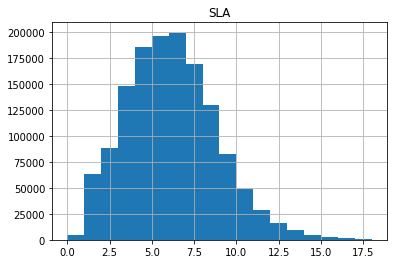

In [1022]:
# Histogram to understand huge demand time slots
ecom.hist(column='SLA',bins=18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000218C93B6208>]],
      dtype=object)

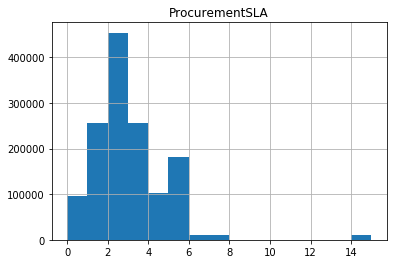

In [1023]:
# Histogram to understand huge demand time slots
ecom.hist(column='ProcurementSLA',bins=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002193EC254A8>]],
      dtype=object)

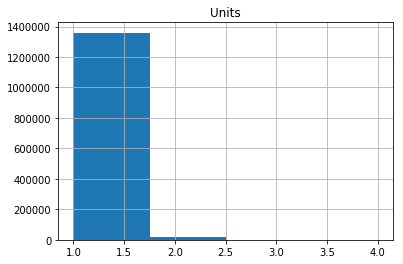

In [1024]:
## Histogram to understand huge demand time slots
ecom.hist(column='Units',bins=4)

In [1025]:
ecom['PP'] = ecom['MRP'].apply(lambda x:'Display_Price_ending_with_99' if str(x).endswith('99') else 'Display_Price_others')

In [1026]:
price_df = pd.get_dummies(ecom['PP'])
price_df.head()

,Display_Price_ending_with_99,Display_Price_others
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0


In [1027]:
ecom = pd.concat([ecom,price_df],axis=1)
ecom.head()

,FSNID,OrderDate,Year,Month,OrderId,OrderItemId,GMV,Units,DeliveryBDay,DeliveryCDays,...,ProductSuperCategory,ProductCategory,ProductSubCategory,ProductVertical,MRP,ProcurementSLA,Week,PP,Display_Price_ending_with_99,Display_Price_others
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000.0,3419300926147000.0,6400.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,42,Display_Price_others,0,1
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200.0,1420830839915200.0,6900.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,43,Display_Price_others,0,1
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800.0,2421912925714800.0,1990.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,43,Display_Price_ending_with_99,1,0
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400.0,4416592101738400.0,1690.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,42,Display_Price_ending_with_99,1,0
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400.0,4419525153426400.0,1618.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,42,Display_Price_ending_with_99,1,0


In [1028]:
ecom.drop(['PP'],axis=1,inplace=True)
ecom.columns

Index(['FSNID', 'OrderDate', 'Year', 'Month', 'OrderId', 'OrderItemId', 'GMV',
       'Units', 'DeliveryBDay', 'DeliveryCDays', 'OrderPaymentType', 'SLA',
       'CustomerId', 'Pincode', 'ProductSuperCategory', 'ProductCategory',
       'ProductSubCategory', 'ProductVertical', 'MRP', 'ProcurementSLA',
       'Week', 'Display_Price_ending_with_99', 'Display_Price_others'],
      dtype='object')

In [1029]:
#filtering the data for the required 3 categories
ecom=ecom[(ecom['ProductSubCategory']=='CameraAccessory')| (ecom['ProductSubCategory']=='HomeAudio')|(ecom['ProductSubCategory']=='GamingAccessory')]

### EDA On the data

- By Payment Type 
- By Category,SubCategory
- By Sales Units
- By GMV, etc

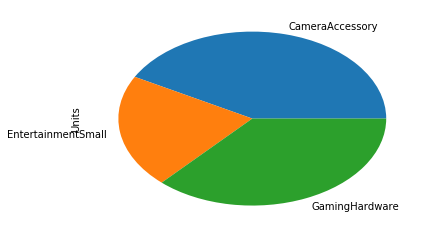

In [1030]:
# Category for Units Sold
ecom.groupby('ProductCategory')['Units'].sum().plot(kind='pie')

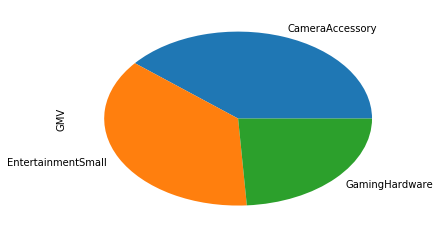

In [1031]:
ecom.groupby('ProductCategory')['GMV'].sum().plot(kind='pie')

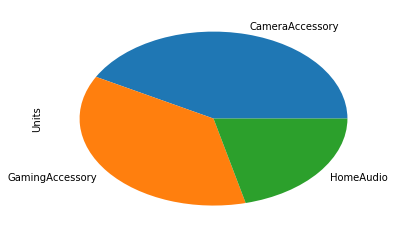

In [1032]:
# SubCategory for Units Sold
ecom.groupby('ProductSubCategory')['Units'].sum().plot(kind='pie')
# Speaker and camera Acessoryies are fast moving items

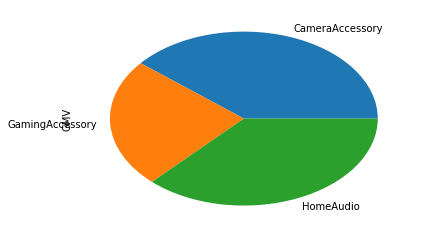

In [1033]:
ecom.groupby('ProductSubCategory')['GMV'].sum().plot(kind='pie')
# Speaker and camera Acessoryies are fast moving items

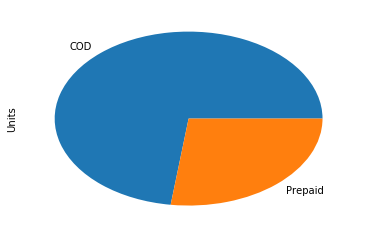

In [1034]:
# Payment type for Units Sold
ecom.groupby('OrderPaymentType')['Units'].sum().plot(kind='pie')
# People trend to buy with COD payment type

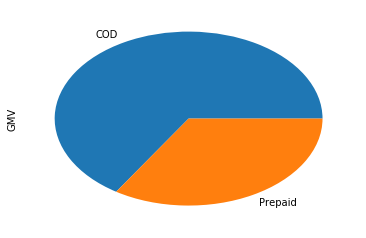

In [1035]:
ecom.groupby('OrderPaymentType')['GMV'].sum().plot(kind='pie')
# People trend to buy with COD payment type

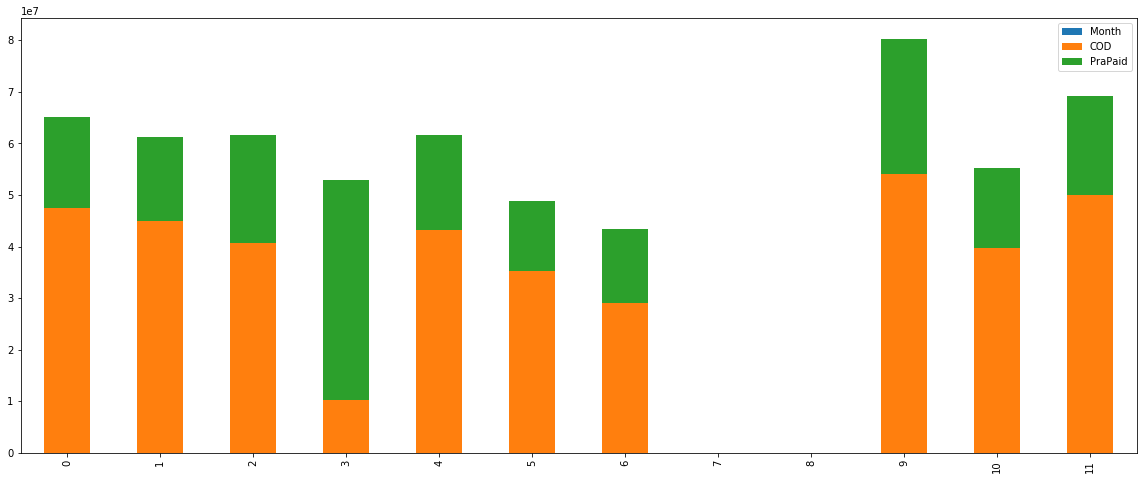

In [1036]:
#Month vs PaymentType
MonthPayment = pd.pivot_table(ecom, index=['Month'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
MonthPayment.columns = MonthPayment.columns.droplevel(1)
MonthPayment.columns = ['Month', 'COD', 'PraPaid']    
MonthPayment.plot(kind="bar", stacked=True,figsize=(20,8))

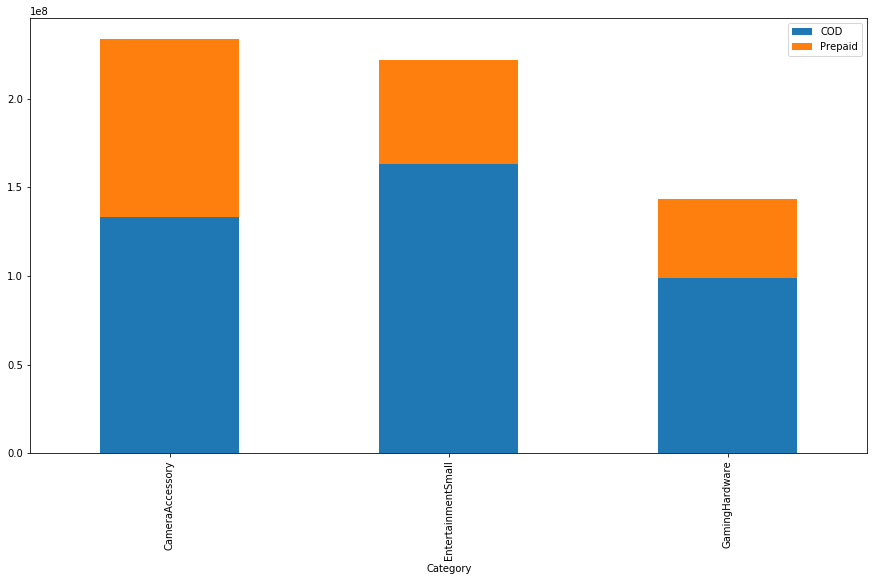

In [1037]:
#Category vs PaymentType
Cat_Payment = pd.pivot_table(ecom, index=['ProductCategory'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
Cat_Payment.columns = Cat_Payment.columns.droplevel(1)
Cat_Payment.columns = ['Category','COD','Prepaid'] 
Cat_Payment.set_index('Category',inplace=True)
Cat_Payment.plot(kind="bar", stacked=True,figsize=(15,8))

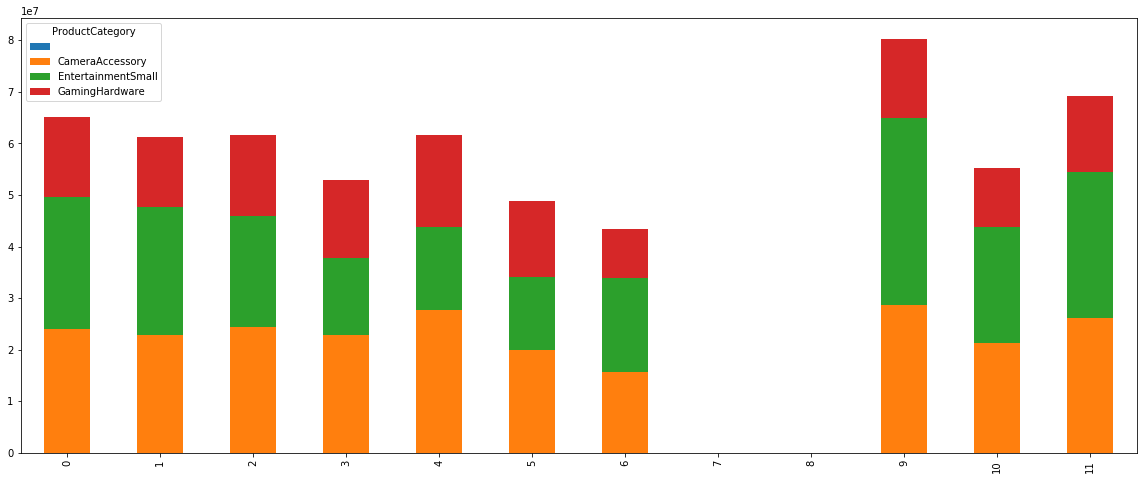

In [1038]:
#Month vs Category
Month_Cat = pd.pivot_table(ecom, index=['Month'],columns=['ProductCategory'],values=['GMV'],aggfunc=np.sum).reset_index()
Month_Cat.columns = Month_Cat.columns.droplevel(0) 
Month_Cat.plot(kind="bar", stacked=True,figsize=(20,8))

In [1039]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
# recaling the variables: MRP,GMV

# filter only MRP, Price
df = ecom.loc[:,['MRP', 'GMV']]
df_columns = df.columns

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,MRP,GMV
0,0.039416,0.043222
1,0.039416,0.046599
2,0.011117,0.013435
3,0.011117,0.011408
4,0.011117,0.010922


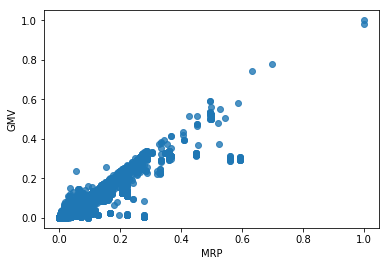

In [1040]:
sns.regplot(x="MRP", y="GMV", data=df, fit_reg=False)

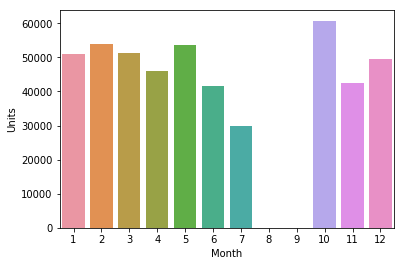

In [1041]:
Month_GMV = pd.pivot_table(ecom, index=['Month'],values=['Units','GMV'],aggfunc=np.sum).reset_index()
sns.barplot(x=Month_GMV.Month, y=Month_GMV.Units)

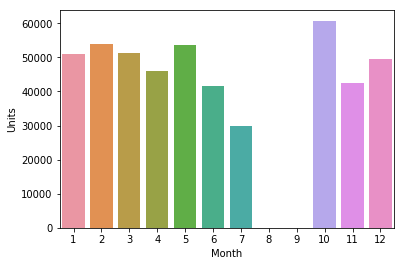

In [1042]:
sns.barplot(x=Month_GMV.Month, y=Month_GMV.Units)

In [1043]:
# Importing Canada Holidays list for 2015 and 2016
Holidays = holidays.Canada(years=[2015,2016], state="ON")
Holidays=pd.DataFrame(Holidays,index=[0]).transpose() 
Holidays.reset_index(level=0, inplace=True)
Holidays['Holidays']= pd.to_datetime(Holidays['index'])
Holidays.drop([Holidays.columns[1]], axis=1, inplace=True)
Holidays.drop([Holidays.columns[0]], axis=1, inplace=True)

In [1044]:
Dt = ecom.loc[:,['OrderDate','Week']]
Dt.head()

,OrderDate,Week
0,2015-10-17 15:11:54,42
1,2015-10-19 10:07:22,43
2,2015-10-20 15:45:56,43
3,2015-10-14 12:05:15,42
4,2015-10-17 21:25:03,42


In [1045]:
Dt['Date'] = Dt['OrderDate'].dt.normalize()
Dt['Month'] = Dt['Date'].dt.month
Dt['Year'] = Dt['Date'].dt.year
Dt['Day'] = Dt['Date'].dt.weekday_name
Dt.head()

,OrderDate,Week,Date,Month,Year,Day
0,2015-10-17 15:11:54,42,2015-10-17,10,2015,Saturday
1,2015-10-19 10:07:22,43,2015-10-19,10,2015,Monday
2,2015-10-20 15:45:56,43,2015-10-20,10,2015,Tuesday
3,2015-10-14 12:05:15,42,2015-10-14,10,2015,Wednesday
4,2015-10-17 21:25:03,42,2015-10-17,10,2015,Saturday


In [1046]:
# Creating array with Special Sale days
SaleDays = pd.to_datetime(['2015-07-18','2015-07-19','2015-08-15','2015-08-16','2015-08-17','2015-08-28','2015-08-29','2015-08-30','2015-10-15','2015-10-16','2015-10-17','2015-11-07','2015-11-08','2015-11-09','2015-11-10','2015-11-11','2015-11-12','2015-11-13','2015-11-14','2015-12-25','2015-12-26','2015-12-27','2015-12-28','2015-12-29','2015-12-30','2015-12-31','2016-01-01','2016-01-02','2016-01-03','2016-01-20','2016-01-21','2016-01-22','2016-02-01','2016-02-02','2016-02-20','2016-02-21','2016-02-14','2016-02-15','2016-03-07','2016-03-08','2016-03-09','2016-03-25','2016-03-26','2016-03-27'])

# Adding SaleDay,Holiday,WeekEnd,Pay Days flag to Date DataFrame
Dt['SaleFlag'] = Dt.apply(lambda x:1 if x.Date in (SaleDays) else 0, axis=1)
Dt['WeekendFlag'] = Dt.apply(lambda x:1 if x.Day in ('Saturday','Sunday') else 0, axis=1)
Dt['PayDayFlag'] = Dt.apply(lambda x:1 if x.Date.day==1 else 0, axis=1)
Dt['HoliDayFlag'] = Dt.apply(lambda x:1 if x.Date in (Holidays.Holidays.tolist()) else 0, axis=1)

Dt.head()

,OrderDate,Week,Date,Month,Year,Day,SaleFlag,WeekendFlag,PayDayFlag,HoliDayFlag
0,2015-10-17 15:11:54,42,2015-10-17,10,2015,Saturday,1,1,0,0
1,2015-10-19 10:07:22,43,2015-10-19,10,2015,Monday,0,0,0,0
2,2015-10-20 15:45:56,43,2015-10-20,10,2015,Tuesday,0,0,0,0
3,2015-10-14 12:05:15,42,2015-10-14,10,2015,Wednesday,0,0,0,0
4,2015-10-17 21:25:03,42,2015-10-17,10,2015,Saturday,1,1,0,0


#### Let's divide the dataset into 3 dataframes based on category.

In [1047]:
GamingAccessory=ecom[(ecom['ProductSubCategory']=='GamingAccessory')]
HomeAudio=ecom[(ecom['ProductSubCategory']=='HomeAudio')]
CameraAccessory=ecom[(ecom['ProductSubCategory']=='CameraAccessory')]

In [1048]:
print(GamingAccessory.shape)
print(HomeAudio.shape)
print(CameraAccessory.shape)

(171939, 23)
(100596, 23)
(197529, 23)


In [1049]:
# Importing Media Investiment and NPS information
ExcelBook = pd.ExcelFile("Media data and other information.xlsx")

# Reading Media Investment and NPS WorkSheet and creating dataset
Media_spend = ExcelBook.parse("Media Investment")
NPS = ExcelBook.parse("Monthly NPS Score")

In [1050]:
# Dropping columns which doesnt have data
Media_spend = Media_spend.drop(['Unnamed: 0'], axis=1)

# Getting column headers 
Header = Media_spend.iloc[0]
Media_spend = Media_spend[1:] 
Media_spend.columns = Header
Media_spend.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
1,2015,7,17.0618,0.21533,2.53301,7.41427,0.000932898,1.32728,0.547254,5.0237,NaN,NaN
2,2015,8,5.06431,0.00643807,1.27807,1.06333,6.32513e-06,0.129244,0.073684,2.51353,NaN,NaN
3,2015,9,96.2544,3.8795,1.35653,62.7877,0.610292,16.38,5.03827,6.20215,NaN,NaN
4,2015,10,170.156,6.14471,12.6225,84.6725,3.44407,24.3718,6.97371,31.927,NaN,NaN
5,2015,11,51.2162,4.22063,1.27547,14.1721,0.168633,19.5616,6.59577,5.22203,NaN,NaN


In [1051]:
Media_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 1 to 16
Data columns (total 12 columns):
Year                 12 non-null object
Month                12 non-null object
Total Investment     12 non-null object
TV                   13 non-null object
Digital              12 non-null object
Sponsorship          12 non-null object
Content Marketing    12 non-null object
Online marketing     12 non-null object
 Affiliates          12 non-null object
SEM                  12 non-null object
Radio                3 non-null object
Other                3 non-null object
dtypes: object(12)
memory usage: 1.6+ KB


In [1052]:
Media_spend['Year'] = pd.to_numeric(Media_spend['Year'], errors='coerce')
Media_spend['Month'] = pd.to_numeric(Media_spend['Month'], errors='coerce')
Media_spend = Media_spend.dropna(subset=['Year','Month'])

In [1053]:
# Converting datatypes from string to float
Media_spend['Total Investment']= Media_spend['Total Investment'].astype(float)
Media_spend['TV']= Media_spend['TV'].astype(float)
Media_spend['Digital']= Media_spend['Digital'].astype(float)
Media_spend['Sponsorship']= Media_spend['Sponsorship'].astype(float)
Media_spend['Content Marketing']= Media_spend['Content Marketing'].astype(float)
Media_spend['Online marketing']= Media_spend['Online marketing'].astype(float)
Media_spend[' Affiliates']= Media_spend[' Affiliates'].astype(float)
Media_spend['SEM']= Media_spend['SEM'].astype(float)
Media_spend['Radio']= Media_spend['Radio'].astype(float)
Media_spend['Other']= Media_spend['Other'].astype(float)
Media_spend['Year']= Media_spend['Year'].astype(int)
Media_spend['Month']= Media_spend['Month'].astype(int)

#Removing Space from Affiliates
Media_spend=Media_spend.rename({" Affiliates": "Affiliates"},axis=1) 

In [1054]:
Media_spend.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
1,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
2,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
3,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
4,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
5,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


In [1055]:
# Adding days in a month to get day investment

# Summarising month days in a month
Month_days = Dt.groupby(['Month'],as_index=False)
Month_days=Month_days.count()
Month_days=Month_days.rename({"Date": "DaysinMonth"},axis=1)
Month_days = Month_days.drop(['Year','Week','Day','SaleFlag','WeekendFlag','PayDayFlag','HoliDayFlag'], axis=1)

Media_spend=pd.merge(Media_spend, Month_days, on=['Month'], how='outer')

# Deriving media spend per day
Media_spend['Total Investment']=(Media_spend['Total Investment'] / Media_spend['DaysinMonth'])
Media_spend['TV']=(Media_spend['TV'] /Media_spend['DaysinMonth'])
Media_spend['Digital']=(Media_spend['Digital'] /Media_spend['DaysinMonth'])
Media_spend['Sponsorship']=(Media_spend['Sponsorship'] /Media_spend['DaysinMonth'])
Media_spend['Content Marketing']=(Media_spend['Content Marketing'] /Media_spend['DaysinMonth'])
Media_spend['Online marketing']=(Media_spend['Online marketing'] /Media_spend['DaysinMonth'])
Media_spend['Affiliates']=(Media_spend['Affiliates'] /Media_spend['DaysinMonth'])
Media_spend['SEM']=(Media_spend['SEM'] /Media_spend['DaysinMonth'])
Media_spend['Radio']=(Media_spend['Radio'] /Media_spend['DaysinMonth'])
Media_spend['Other']=(Media_spend['Other'] /Media_spend['DaysinMonth'])


In [1056]:
NPS.transpose=pd.DataFrame(NPS.T)
NPS.transpose
df_NPS=NPS.transpose.rename(columns=NPS.transpose.iloc[0]).drop(NPS.transpose.index[0])

In [1057]:
df_monthly_nps=pd.DataFrame({'index':[1,2,3,4,5,6,7,8,9,10,11,12],
                            'Year' : [2015,2015,2015,2015,2015,2015,2016,2016,2016,2016,2016,2016],
                            'Month' :[7,8,9,10,11,12,1,2,3,4,5,6]})
df_monthly_nps

,index,Year,Month
0,1,2015,7
1,2,2015,8
2,3,2015,9
3,4,2015,10
4,5,2015,11
5,6,2015,12
6,7,2016,1
7,8,2016,2
8,9,2016,3
9,10,2016,4


In [1058]:
colls=['NPS', 'Stock Index', 'index']
df_NPS.reset_index()
df_NPS['index']=range(1,13)
df_NPS[colls]=df_NPS[colls].apply(pd.to_numeric)
df_NPS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, July'15 to June'16
Data columns (total 3 columns):
NPS            12 non-null float64
Stock Index    12 non-null float64
index          12 non-null int32
dtypes: float64(2), int32(1)
memory usage: 336.0+ bytes


In [1059]:
df_monthlynps=pd.merge(df_monthly_nps,df_NPS,how='inner', on='index')

In [1060]:
df_monthlynps

,index,Year,Month,NPS,Stock Index
0,1,2015,7,54.599588,1177.0
1,2,2015,8,59.987101,1206.0
2,3,2015,9,46.925419,1101.0
3,4,2015,10,44.398389,1210.0
4,5,2015,11,47.000000,1233.0
5,6,2015,12,45.800000,1038.0
6,7,2016,1,47.093031,1052.0
7,8,2016,2,50.327406,1222.0
8,9,2016,3,49.020550,1015.0
9,10,2016,4,51.827605,1242.0


In [1061]:
Dt=pd.merge(Dt, Media_spend, on=['Year','Month'], how='outer')

In [1062]:
Dt=pd.merge(Dt, df_monthlynps, on=['Year','Month'], how='outer')

In [1063]:
# Summarising Media Spend , Holidays,Special Sale Days,PayDays at one level
WeekSpend = pd.pivot_table(Dt, index=['Week'],values=['Total Investment','TV','Digital','Sponsorship','Content Marketing','Online marketing','Affiliates','SEM','Radio','Other',
'SaleFlag','WeekendFlag','PayDayFlag','HoliDayFlag'],aggfunc=[np.sum]).reset_index()
WeekSpend.columns = ['Week','Affiliates','ContentMarketing','Digital','HoliDays','OnlineMarketing','Other','PayDays','Radio','SEM','SaleDays','Sponsorship','TV','TotalInvestment','WkEnds']   


In [1064]:
WeekSpendPT2 = pd.pivot_table(Dt, index=['Week'],values=['NPS'],aggfunc=[np.mean]).reset_index()
WeekSpendPT2.columns = ['Week','NPS']

In [1065]:
WeekSpend=pd.merge(WeekSpend, WeekSpendPT2, on=['Week'], how='outer')
WeekSpend.head(5)

,Week,Affiliates,ContentMarketing,Digital,HoliDays,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,WkEnds,NPS
0,27,0.001714,0.000003,0.007933,6,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,16,54.599588
1,28,0.147832,0.000252,0.684252,0,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,2275,54.599588
2,29,0.153708,0.000262,0.711451,0,0.372794,0.0,0,0.0,1.411013,2253,2.082456,0.060480,4.792165,2253,54.599588
3,30,0.143952,0.000245,0.666293,0,0.349132,0.0,0,0.0,1.321452,0,1.950278,0.056641,4.487994,2177,54.599588
4,31,0.113318,0.000171,0.700195,0,0.265561,0.0,1,0.0,1.384702,0,1.547447,0.040359,4.051752,3,54.602646


In [1066]:
print(ecom.shape) # checking Dataset size
print(ecom['ProductSubCategory'].unique()) # subcategory values

(470064, 23)
['CameraAccessory' 'GamingAccessory' 'HomeAudio']


In [1067]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470064 entries, 0 to 1437935
Data columns (total 23 columns):
FSNID                           470064 non-null object
OrderDate                       470064 non-null datetime64[ns]
Year                            470064 non-null int64
Month                           470064 non-null int64
OrderId                         470064 non-null object
OrderItemId                     470064 non-null object
GMV                             470064 non-null float64
Units                           470064 non-null int64
DeliveryBDay                    470064 non-null float64
DeliveryCDays                   470064 non-null float64
OrderPaymentType                470064 non-null object
SLA                             470064 non-null int64
CustomerId                      470064 non-null float64
Pincode                         470064 non-null float64
ProductSuperCategory            470064 non-null object
ProductCategory                 470064 non-null object

### Creating KPIs
1. KPI - List price for all the products
2. KPI - Promotional Offer for all the products
3. Clustering- Creating a new KPI.It divides the products into three categories based on MRP and num units sold - mass market, medium market and premium product
4. Payment model indicator

In [1069]:
### KPI ###
# Identifying Listing Price
ecom["ListingPrice"]=(ecom["GMV"]/ecom["Units"])

# KPI for Promotional Offers
ecom["PromoOffer"]=(ecom["MRP"]-ecom["ListingPrice"])/ecom["GMV"]

ecom["Delivery_time"] =ecom["SLA"] - (ecom["DeliveryBDay"]+ecom["DeliveryCDays"]+ecom["ProcurementSLA"])
ecom["Delivery_status"] = ecom["Delivery_time"].apply(lambda x: 'Arriving_Early' if x<0 else('On_Time' if x==0  else 'Delayed'))
delivery_stat = pd.get_dummies(ecom["Delivery_status"])
ecom = pd.concat([ecom, delivery_stat], axis = 1)
ecom.drop(['Delivery_status'], axis = 1, inplace = True)


# KPI for deriving Onlinepayment i.e PrePaid Rate
ecom['PaymentType_alt'] = ecom.apply(lambda x:'COD' if x.OrderPaymentType=='COD' else 'Others', axis=1)
ecom['OrderPaymentType'] = ecom.apply(lambda x:0 if x.OrderPaymentType=='COD' else 1, axis=1)
payment_type = pd.get_dummies(ecom['PaymentType_alt'])
ecom = pd.concat([ecom, payment_type],axis=1)
Prepaid_Orders = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['OrderPaymentType'],aggfunc=[len,np.sum]).reset_index().rename(columns={'len': 'TotalOrders','sum': 'OnlineOrders'})
Prepaid_Orders.columns = Prepaid_Orders.columns.droplevel(1)
ecom.drop(['PaymentType_alt'], axis = 1, inplace = True)

Prepaid_Orders["OnlinePayRate"]=100*(Prepaid_Orders["OnlineOrders"]/Prepaid_Orders["TotalOrders"])
Prepaid_Orders = Prepaid_Orders.drop(['TotalOrders','OnlineOrders'], axis=1)
Prepaid_Orders.columns = ['ProductSubCategory','Week','OnlinePayRate'] 
Prepaid_Orders.head(5)

# KPI  for Price Tag by Vertical using Units MRP andListing Price with help of ClusterAnalysis
Cluster = pd.pivot_table(ecom, index=['ProductVertical'],values=['Units','MRP','ListingPrice'],aggfunc=np.sum).reset_index()

In [1070]:
# understanding Product based on Price units sold using KMeans Cluster
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters = 3)
Y_Pred=kmean.fit_predict(Cluster[['Units','MRP','ListingPrice']])
Cluster['Cluster'] = Y_Pred
Cluster.head(5)

,ProductVertical,ListingPrice,MRP,Units,Cluster
0,Binoculars,2.335195e+07,38618316,12122,0
1,BoomBox,6.526150e+06,7955342,1987,0
2,CameraAccessory,1.147502e+06,1908840,1590,0
3,CameraBag,2.072171e+07,32342135,14754,0
4,CameraBattery,1.931267e+07,43933647,32371,0


In [1071]:
Cluster['PriceTag'] = Cluster.apply(lambda x:'Mass' if x.Cluster==2 else 'Premium' if x.Cluster==0 else 'Aspiring', axis=1)
Cluster_new = Cluster.drop(['Units','MRP','ListingPrice','Cluster'], axis=1)

In [1072]:
# Joining Price Tag to Transaction data at Vertical Level
ecom=pd.merge(ecom, Cluster_new, on=['ProductVertical'], how='outer')

In [1073]:
# Joining Prepaid rate to Transaction data at Subcategory & Week Level
ecom=pd.merge(ecom, Prepaid_Orders, on=['ProductSubCategory','Week'], how='outer')

In [1074]:
vertical = pd.get_dummies(ecom['ProductVertical'])
ecom = pd.concat([ecom, vertical], axis = 1)

In [1075]:
ecom.columns

Index(['FSNID', 'OrderDate', 'Year', 'Month', 'OrderId', 'OrderItemId', 'GMV',
       'Units', 'DeliveryBDay', 'DeliveryCDays', 'OrderPaymentType', 'SLA',
       'CustomerId', 'Pincode', 'ProductSuperCategory', 'ProductCategory',
       'ProductSubCategory', 'ProductVertical', 'MRP', 'ProcurementSLA',
       'Week', 'Display_Price_ending_with_99', 'Display_Price_others',
       'ListingPrice', 'PromoOffer', 'Delivery_time', 'Arriving_Early',
       'Delayed', 'On_Time', 'COD', 'Others', 'PriceTag', 'OnlinePayRate',
       'Binoculars', 'BoomBox', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'CoolingPad',
       'DJController', 'Dock', 'DockingStation', 'ExtensionTube', 'FMRadio',
       'Filter', 'Flash', 'FlashShoeAdapter', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAd

In [1076]:
# Generating Weeklevel aggeration data from transaction data for modeling
TransSC = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['GMV','Units','PromoOffer','Arriving_Early', 
'Delayed' , 'On_Time','Display_Price_ending_with_99','Display_Price_others','COD', 'Others', 'Binoculars', 'BoomBox',
'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
'CameraTripod', 'CoolingPad', 'DJController', 'Dock', 'DockingStation',
'ExtensionTube', 'FMRadio', 'Filter', 'Flash', 'FlashShoeAdapter',
'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
'HiFiSystem', 'HomeAudioSpeaker', 'JoystickGamingWheel',
'KaraokePlayer', 'Lens', 'MotionController', 'ReflectorUmbrella',
'SlingBox', 'Softbox', 'SoundMixer', 'Strap', 'TVOutCableAccessory',
'Teleconverter', 'Telescope', 'VoiceRecorder'],aggfunc=[np.sum]).reset_index()


In [1077]:
TransSC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 61 columns):
(ProductSubCategory, )                 144 non-null object
(Week, )                               144 non-null int64
(sum, Arriving_Early)                  144 non-null float64
(sum, Binoculars)                      144 non-null float64
(sum, BoomBox)                         144 non-null uint8
(sum, COD)                             144 non-null float64
(sum, CameraAccessory)                 144 non-null uint8
(sum, CameraBag)                       144 non-null float64
(sum, CameraBattery)                   144 non-null float64
(sum, CameraBatteryCharger)            144 non-null float64
(sum, CameraBatteryGrip)               144 non-null uint8
(sum, CameraEyeCup)                    144 non-null uint8
(sum, CameraFilmRolls)                 144 non-null uint8
(sum, CameraHousing)                   144 non-null uint8
(sum, CameraMicrophone)                144 non-null uint8
(sum, Camera

In [1078]:
TransSC.columns = ['ProductSubCategory','Week','Arriving_Early','Binoculars', 'BoomBox','COD','CameraAccessory', 
                   'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'CoolingPad', 'DJController','Delayed',
        'Display_Price_ending_with_99','Display_Price_others','Dock', 'DockingStation',
       'ExtensionTube', 'FMRadio', 'Filter', 'Flash', 'FlashShoeAdapter','GMV',
        'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'HiFiSystem', 'HomeAudioSpeaker', 'JoystickGamingWheel',
       'KaraokePlayer', 'Lens', 'MotionController',
       'On_Time','Others','PromoOffer','ReflectorUmbrella',
       'SlingBox', 'Softbox', 'SoundMixer', 'Strap', 'TVOutCableAccessory',
       'Teleconverter', 'Telescope',
        'Units', 'VoiceRecorder'] 

In [1079]:
# Sped is in Crs since GMV needs to be converted to Crs
TransSC['GMV']=TransSC['GMV']/10000000

In [1080]:
#Weeklevel aggeration data from transaction data for modeling more varibles
Agg = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['MRP','ProcurementSLA','SLA','DeliveryBDay','DeliveryCDays'],aggfunc=[np.mean]).reset_index()
Agg.columns = ['ProductSubCategory','Week','DeliveryBDays','DeliveryCDays','SLA','MRP','ProcurementSLA'] 
Agg.head(5)

,ProductSubCategory,Week,DeliveryBDays,DeliveryCDays,SLA,MRP,ProcurementSLA
0,CameraAccessory,27,0.807692,0.846154,1511.961538,2.846154,2.384615
1,CameraAccessory,28,0.000000,0.000000,2492.739756,2.757009,7.035586
2,CameraAccessory,29,0.000000,0.000000,2578.240574,2.788455,6.385385
3,CameraAccessory,30,0.000000,0.000000,2565.440541,2.842905,6.405743
4,CameraAccessory,31,0.000000,0.000000,2513.944982,2.795211,6.373408


In [1081]:
# Joining Transactional Week aggregation data
TransSC=pd.merge(TransSC, Agg, on=['ProductSubCategory','Week'], how='outer')

In [1082]:
# Joining PrepaidRate to transactional Week aggregation data
TransSC=pd.merge(TransSC, Prepaid_Orders, on=['ProductSubCategory','Week'], how='outer')


In [1083]:
# Joining Weekly Spend to transactional Week aggregation data
# WeekEnds is constant for a week hence may not be useful hence dropping
WeekSpend = WeekSpend.drop(['WkEnds'], axis=1)
TransSC=pd.merge(TransSC, WeekSpend, on=['Week'], how='outer')
TransSC.head(5)

,ProductSubCategory,Week,Arriving_Early,Binoculars,BoomBox,COD,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,...,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,NPS
0,CameraAccessory,27,20.0,1.0,0,0.0,1,2.0,4.0,1.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
1,GamingAccessory,27,19.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
2,HomeAudio,27,26.0,0.0,5,1.0,0,0.0,0.0,0.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
3,CameraAccessory,28,287.0,203.0,0,1869.0,42,331.0,642.0,220.0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588
4,GamingAccessory,28,864.0,0.0,0,2203.0,0,0.0,0.0,0.0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588



# Camera Accessories 

- EDA ,Correlation,Linear Model Building with feature Engineering

In [1084]:
# Generating Camera Accessories Transactional Data
Camera=ecom.drop(ecom[(ecom.ProductSubCategory != 'CameraAccessory')].index)

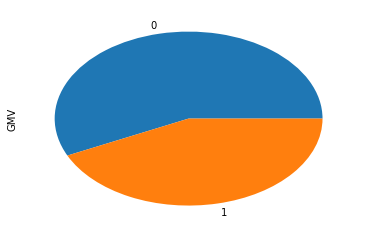

In [1085]:
# Pie chart for COD and Prepaid Orders
Camera.groupby('OrderPaymentType')['GMV'].sum().plot(kind='pie')

In [1086]:
ecom['OrderPaymentType'].nunique()

2

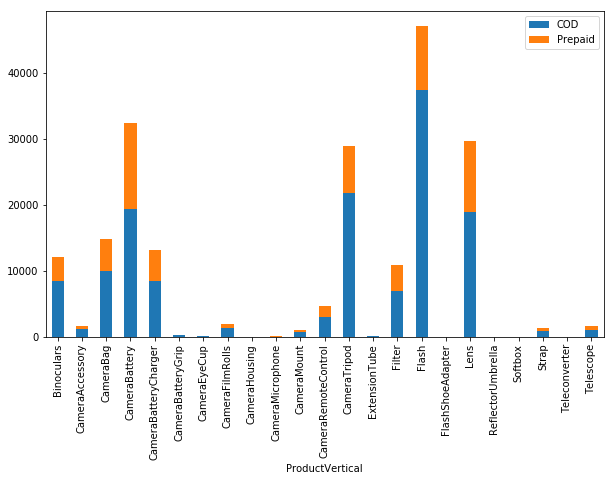

In [1087]:
# Payment Type by Vertical sales view by units
CA = pd.pivot_table(Camera, index=['ProductVertical'],columns=['OrderPaymentType'],values=['Units'],aggfunc=np.sum).reset_index()
CA.columns = CA.columns.droplevel(1)
CA.columns = ['ProductVertical','COD','Prepaid'] 
CA.set_index('ProductVertical',inplace=True)
CA.plot(kind="bar", stacked=True,figsize=(10,6))

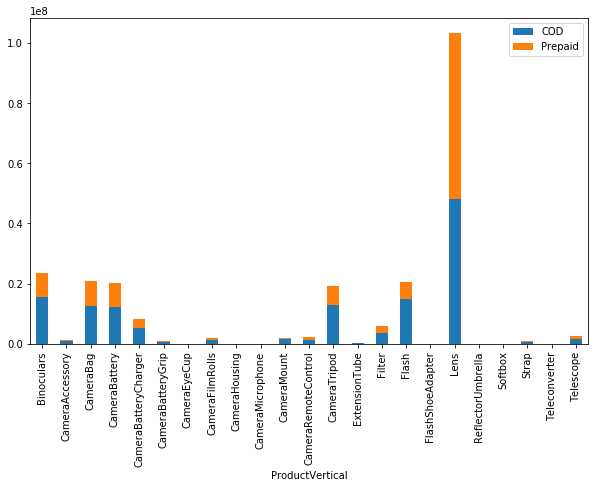

In [1088]:
# Payment Type by Vertical sales view by GMV
CA = pd.pivot_table(Camera, index=['ProductVertical'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
CA.columns = CA.columns.droplevel(1)
CA.columns = ['ProductVertical','COD','Prepaid'] 
CA.set_index('ProductVertical',inplace=True)
CA.plot(kind="bar", stacked=True,figsize=(10,6))

In [1089]:
## output generation for Tablue
TransSC.to_csv("TransSC.csv", sep='\t', encoding='utf-8')

In [1090]:
# Generating Data Frames for each Surver category week level aggregation data
WL_camera=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'CameraAccessory')].index)
print(WL_camera.shape)
WL_Game=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'GamingAccessory')].index)
print(WL_Game.shape)
WL_Homeaudio=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'HomeAudio')].index)
print(WL_Homeaudio.shape)

(48, 81)
(50, 81)
(46, 81)


In [1096]:
CA_col = Camera['ProductVertical'].unique()
print(sorted(CA_col))
#for items in df_CA_RD

['Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Teleconverter', 'Telescope']


In [1097]:
df_CA1 = WL_camera.copy()
for items in WL_camera.columns:
    if items not in CA_col and items in vertical.columns:
        del WL_camera[items]

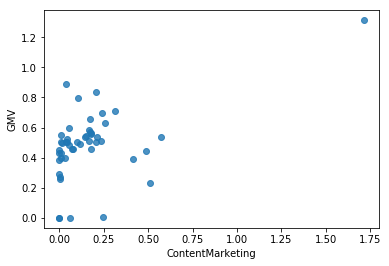

In [1098]:
# Scater plot for GMV Generated by Sped type ContentMarketing
sns.regplot(x="ContentMarketing", y="GMV", data=WL_camera[['ContentMarketing','GMV']], fit_reg=False)

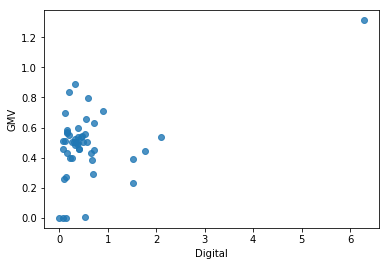

In [1099]:
# Scater plot for GMV Generated by Sped type Digital
sns.regplot(x="Digital", y="GMV", data=WL_camera[['Digital','GMV']], fit_reg=False)

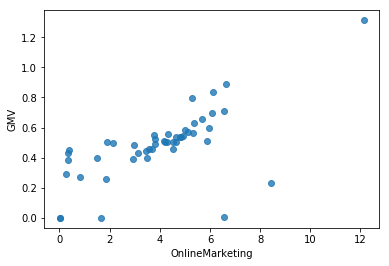

In [1100]:
# Scater plot for GMV Generated by Sped type OnlineMarketing
sns.regplot(x="OnlineMarketing", y="GMV", data=WL_camera[['OnlineMarketing','GMV']], fit_reg=False)

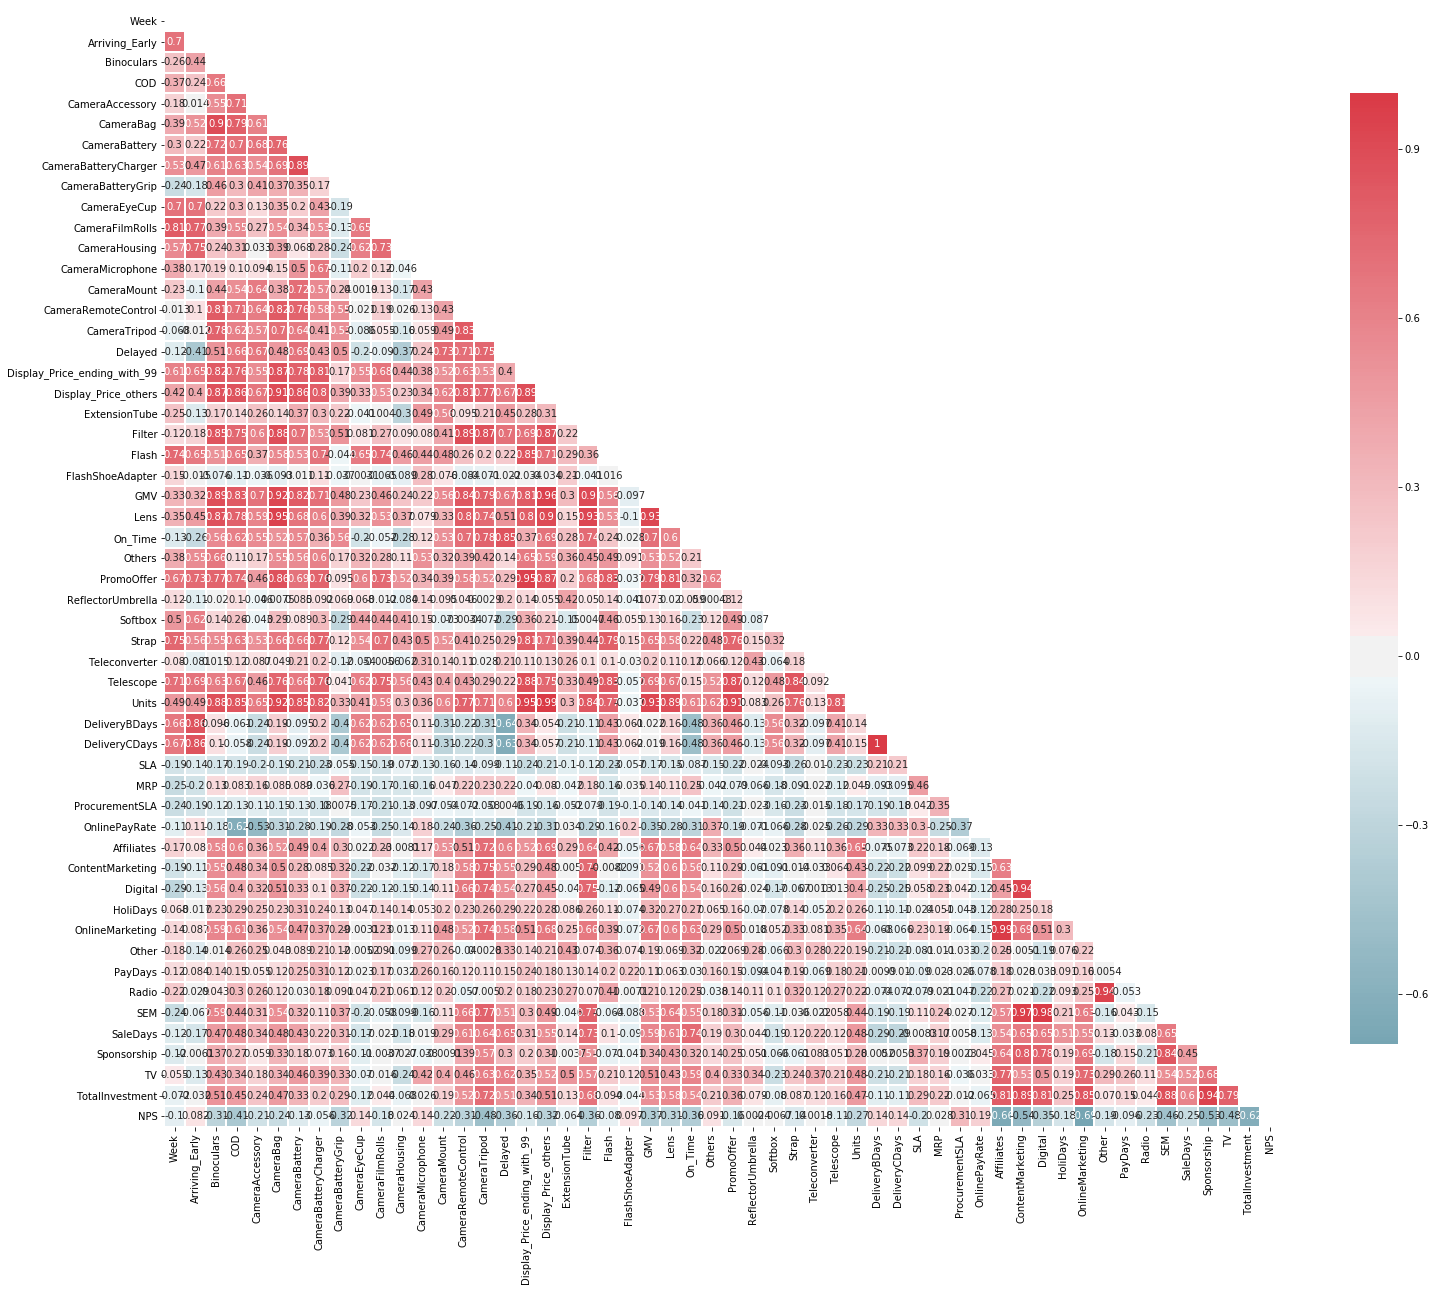

In [1101]:
# Corelation matrix
corr=WL_camera.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

In [1102]:
WL_camera.set_index("Week", inplace = True) 


In [1103]:
WL_camera = WL_camera.drop(['ProductSubCategory'], axis=1)
WL_camera.head()

,Arriving_Early,Binoculars,COD,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,...,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,NPS
Week,,,,,,,,,,,,,,,,,,,,,
27,20.0,1.0,0.0,1,2.0,4.0,1.0,0,0,0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
28,287.0,203.0,1869.0,42,331.0,642.0,220.0,11,0,0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588
29,377.0,264.0,1986.0,30,351.0,702.0,219.0,6,0,0,...,0.372794,0.0,0,0.0,1.411013,2253,2.082456,0.060480,4.792165,54.599588
30,335.0,220.0,1998.0,41,291.0,730.0,265.0,9,0,0,...,0.349132,0.0,0,0.0,1.321452,0,1.950278,0.056641,4.487994,54.599588
31,211.0,156.0,1371.0,40,188.0,448.0,175.0,9,0,0,...,0.265561,0.0,1,0.0,1.384702,0,1.547447,0.040359,4.051752,54.602646


In [1104]:
# Creating AddStock variavle for all spend variable with R=50%

def calculate_ad_stocks(data, engagement_factor):
    
    #initialize ad stock vector
    ad_stock_vector = []
    #initialize ad_stock_value
    ad_stock_value = 0
    #loop through dataset to calculate ad stock values
    for index, row in data.iterrows():
        ad_stock_value = row[0] + ad_stock_value * engagement_factor
        ad_stock_vector.append(ad_stock_value)
    #add ad stock vector to dataset
    data['ad_stock'] = ad_stock_vector
    return data

TV_ad_stocks = calculate_ad_stocks(data=WL_camera[['TV']],engagement_factor=0.5)
TV_ad_stocks.columns = ['TV','TV_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera[['GMV','Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 
        'ExtensionTube', 'Filter', 'Flash',
       'FlashShoeAdapter', 'Lens',  'ReflectorUmbrella', 'Softbox',
       'Strap',  'Teleconverter',
       'Telescope', 'Units', 'NPS','Arriving_Early','On_Time','Delayed',
        'PromoOffer','Display_Price_ending_with_99','Display_Price_others',
        #'COD','Others','PayDays','NotPayDays','HoliDays','NotHolidays','SaleDays','NotSaleDays']], TV_ad_stocks, on=['Week'], how='outer')
        'COD','Others','PayDays','HoliDays','SaleDays']], TV_ad_stocks, on=['Week'], how='outer')

Affiliates_ad_stocks = calculate_ad_stocks(data=WL_camera[['Affiliates']],engagement_factor=0.5)
Affiliates_ad_stocks.columns = ['Affiliates','Affiliates_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, Affiliates_ad_stocks, on=['Week'], how='outer')


ContentMarketing_ad_stocks = calculate_ad_stocks(data=WL_camera[['ContentMarketing']],engagement_factor=0.5)
ContentMarketing_ad_stocks.columns = ['ContentMarketing','ContentMarketing_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, ContentMarketing_ad_stocks, on=['Week'], how='outer')

Digital_ad_stocks = calculate_ad_stocks(data=WL_camera[['Digital']],engagement_factor=0.5)
Digital_ad_stocks.columns = ['Digital','Digital_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, Digital_ad_stocks, on=['Week'], how='outer')

OnlineMarketing_ad_stocks = calculate_ad_stocks(data=WL_camera[['OnlineMarketing']],engagement_factor=0.5)
OnlineMarketing_ad_stocks.columns = ['OnlineMarketing','OnlineMarketing_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, OnlineMarketing_ad_stocks, on=['Week'], how='outer')

Other_ad_stocks = calculate_ad_stocks(data=WL_camera[['Other']],engagement_factor=0.5)
Other_ad_stocks.columns = ['Other','Other_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, Other_ad_stocks, on=['Week'], how='outer')

Radio_ad_stocks = calculate_ad_stocks(data=WL_camera[['Radio']],engagement_factor=0.5)
Radio_ad_stocks.columns = ['Radio','Radio_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, Radio_ad_stocks, on=['Week'], how='outer')

SEM_ad_stocks = calculate_ad_stocks(data=WL_camera[['SEM']],engagement_factor=0.5)
SEM_ad_stocks.columns = ['SEM','SEM_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, SEM_ad_stocks, on=['Week'], how='outer')

Sponsorship_ad_stocks = calculate_ad_stocks(data=WL_camera[['Sponsorship']],engagement_factor=0.5)
Sponsorship_ad_stocks.columns = ['Sponsorship','Sponsorship_Ad_Stock'] 
WL_camera_M=pd.merge(WL_camera_M, Sponsorship_ad_stocks, on=['Week'], how='outer')


In [1105]:
WL_camera_M.head()

,GMV,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,...,OnlineMarketing,OnlineMarketing_Ad_Stock,Other,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock
Week,,,,,,,,,,,,,,,,,,,,,
27,0.001752,1.0,1,2.0,4.0,1.0,0,0,0,0,...,0.004157,0.004157,0.0,0.0,0.0,0.0,0.015734,0.015734,0.023221,0.023221
28,0.385017,203.0,42,331.0,642.0,220.0,11,0,0,0,...,0.358542,0.360621,0.0,0.0,0.0,0.0,1.357069,1.364936,2.002843,2.014453
29,0.450789,264.0,30,351.0,702.0,219.0,6,0,0,0,...,0.372794,0.553105,0.0,0.0,0.0,0.0,1.411013,2.093481,2.082456,3.089683
30,0.433094,220.0,41,291.0,730.0,265.0,9,0,0,0,...,0.349132,0.625684,0.0,0.0,0.0,0.0,1.321452,2.368193,1.950278,3.495119
31,0.290338,156.0,40,188.0,448.0,175.0,9,0,0,0,...,0.265561,0.578403,0.0,0.0,0.0,0.0,1.384702,2.568798,1.547447,3.295006


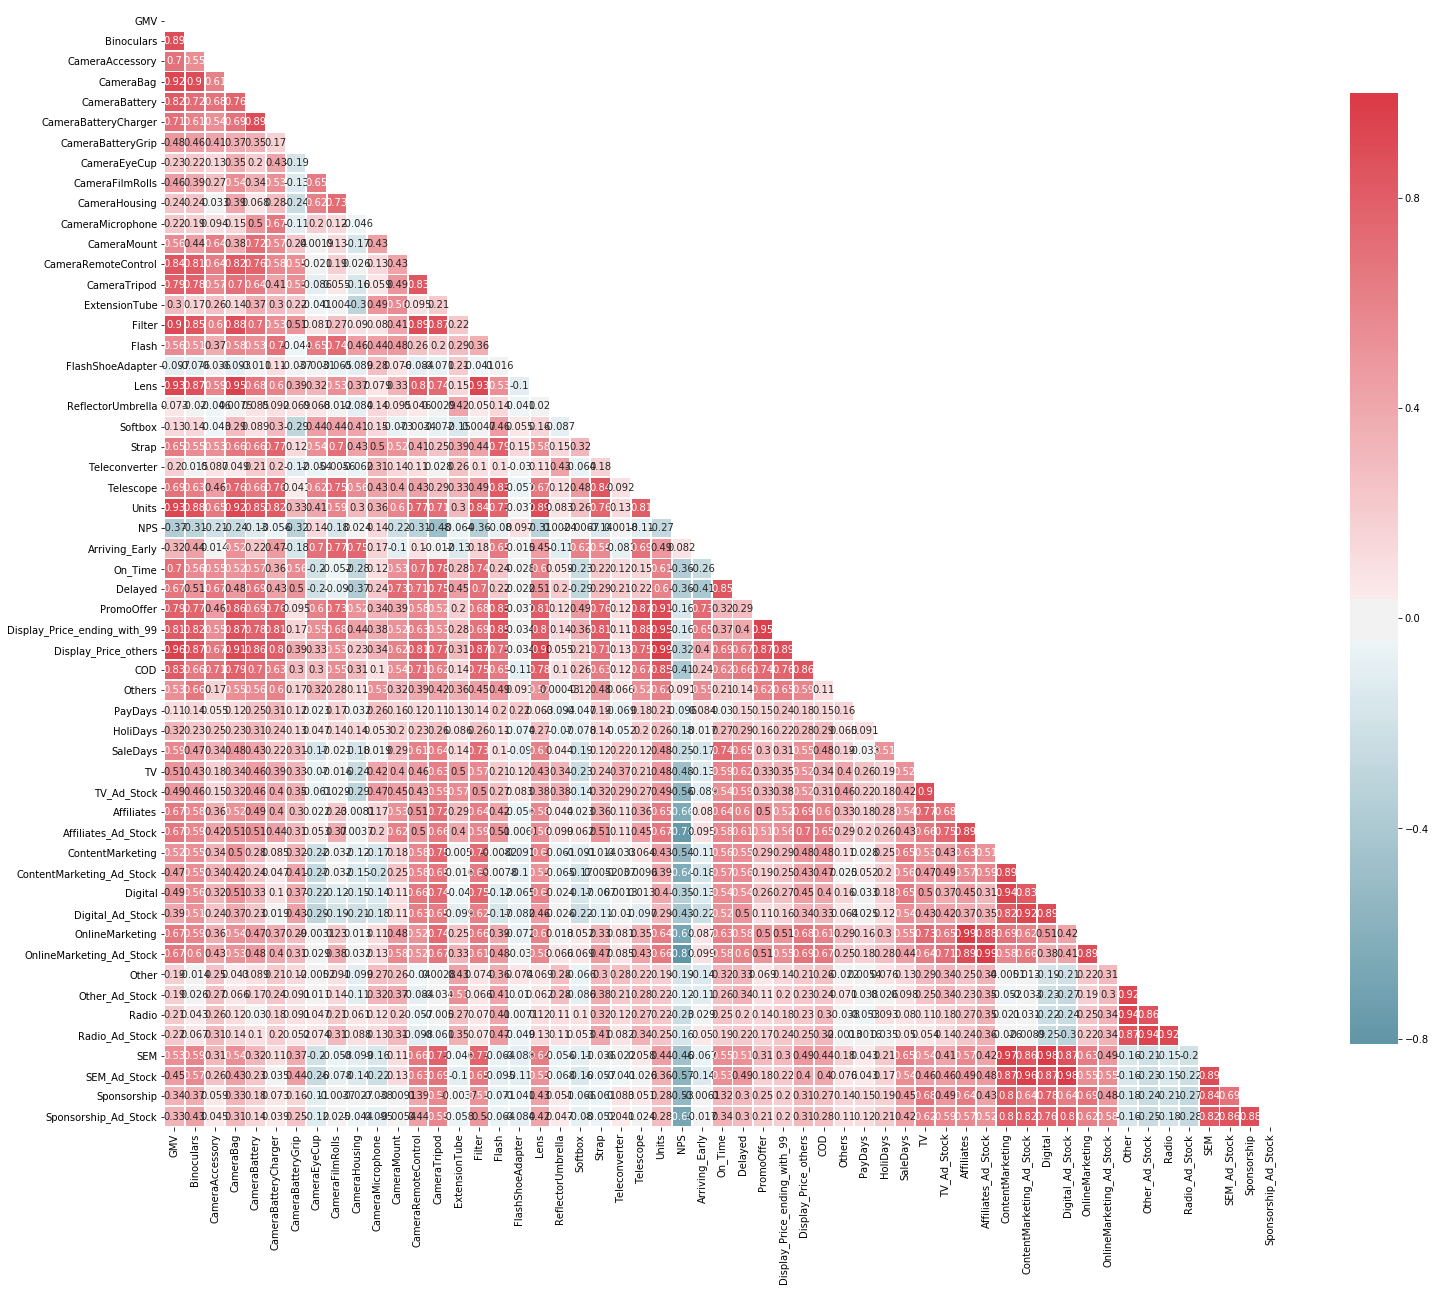

In [1518]:
# Corelation matrix
corr=WL_camera_M.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

# Splitting the data into training nad test data
We have to specify this so that the train and test data set always have the same rows, respectively

In [1733]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(WL_camera_M, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1734]:
# Creating Predicter and influencer variable for Lenier Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [1735]:
# RFE to identify significant variavles in Media spend
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Binoculars', False, 9),
 ('CameraAccessory', False, 19),
 ('CameraBag', False, 10),
 ('CameraBattery', False, 17),
 ('CameraBatteryCharger', False, 11),
 ('CameraBatteryGrip', False, 26),
 ('CameraEyeCup', False, 29),
 ('CameraFilmRolls', False, 5),
 ('CameraHousing', True, 1),
 ('CameraMicrophone', False, 2),
 ('CameraMount', False, 4),
 ('CameraRemoteControl', False, 22),
 ('CameraTripod', False, 13),
 ('ExtensionTube', True, 1),
 ('Filter', False, 8),
 ('Flash', False, 12),
 ('FlashShoeAdapter', True, 1),
 ('Lens', False, 18),
 ('ReflectorUmbrella', False, 35),
 ('Softbox', True, 1),
 ('Strap', False, 7),
 ('Teleconverter', False, 34),
 ('Telescope', False, 27),
 ('Units', False, 28),
 ('NPS', True, 1),
 ('Arriving_Early', False, 25),
 ('On_Time', False, 23),
 ('Delayed', False, 24),
 ('PromoOffer', False, 31),
 ('Display_Price_ending_with_99', False, 21),
 ('Display_Price_others', False, 20),
 ('COD', False, 14),
 ('Others', False, 15),
 ('PayDays', False, 33),
 ('HoliDays', Fal

In [1736]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'Filter', 'Flash', 'Lens',
       'ReflectorUmbrella', 'Strap', 'Teleconverter', 'Telescope', 'Units',
       'Arriving_Early', 'On_Time', 'Delayed', 'PromoOffer',
       'Display_Price_ending_with_99', 'Display_Price_others', 'COD', 'Others',
       'PayDays', 'HoliDays', 'SaleDays', 'OnlineMarketing',
       'OnlineMarketing_Ad_Stock', 'Sponsorship_Ad_Stock'],
      dtype='object')

In [1737]:
import statsmodels.api as sm
# build simple simple lenier model

X_train = X_train[col]
X_train_lm = sm.add_constant(X_train)
lr1 = sm.OLS(y_train, X_train_lm).fit()

# View summary
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     16.37
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.43e-06
Time:                        10:20:53   Log-Likelihood:                 59.308
No. Observations:                  33   AIC:                            -76.62
Df Residuals:                      12   BIC:                            -45.19
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1738]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
18,SEM,34132.22
19,SEM_Ad_Stock,26384.08
15,Other_Ad_Stock,24131.11
12,Digital,23512.82
17,Radio_Ad_Stock,21963.76
14,Other,15143.27
13,Digital_Ad_Stock,14876.60
16,Radio,14699.56
0,const,10318.79
7,TV_Ad_Stock,2392.63


In [1739]:

# Affiliates_Ad_Stock has p value of 0.991 (not significant) with VIF 22216.80 which is insignificatant so drop this variable
X_train = X_train.drop(['TV_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     18.66
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.66e-06
Time:                        10:20:55   Log-Likelihood:                 59.307
No. Observations:                  33   AIC:                            -78.61
Df Residuals:                      13   BIC:                            -48.68
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1740]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,SEM,17139.71
11,Digital,12684.28
0,const,10272.35
18,SEM_Ad_Stock,5099.00
12,Digital_Ad_Stock,2859.30
15,Radio,2490.37
13,Other,2233.74
14,Other_Ad_Stock,910.16
16,Radio_Ad_Stock,861.19
9,ContentMarketing,838.64


In [1741]:
# OnlineMarketing has p value of 0.747 (not significant) with VIF 6384.98 which is insignificatant so drop this variable
X_train = X_train.drop(['Digital_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr3 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr3.summary())


                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     20.89
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.83e-07
Time:                        10:20:58   Log-Likelihood:                 59.060
No. Observations:                  33   AIC:                            -80.12
Df Residuals:                      14   BIC:                            -51.69
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1742]:
# Radio has p value of 0.899 (not significant) with VIF 2324.61 which is insignificatant so drop this variable
X_train = X_train.drop(['Radio_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr4 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     23.57
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.87e-08
Time:                        10:20:59   Log-Likelihood:                 58.979
No. Observations:                  33   AIC:                            -81.96
Df Residuals:                      15   BIC:                            -55.02
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1743]:
# Digital_Ad_Stock has p value of 0.805 (not significant) with VIF 235.32 which is insignificatant so drop this variable
X_train = X_train.drop(['Affiliates'], 1,)
X_train_lm = sm.add_constant(X_train)
lr5 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     26.01
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.80e-08
Time:                        10:21:00   Log-Likelihood:                 58.550
No. Observations:                  33   AIC:                            -83.10
Df Residuals:                      16   BIC:                            -57.66
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1744]:
# SEM has p value of 0.610 (not significant) with VIF 2076.10 which is insignificatant so drop this variable
X_train = X_train.drop(['Other_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr6 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     27.86
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.01e-09
Time:                        10:21:01   Log-Likelihood:                 57.656
No. Observations:                  33   AIC:                            -83.31
Df Residuals:                      17   BIC:                            -59.37
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1745]:
# Other has p value of 0.521 (not significant) with VIF 22.43 which is insignificatant so drop this variable
X_train = X_train.drop(['SEM_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr7 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     28.43
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.10e-09
Time:                        10:21:03   Log-Likelihood:                 55.981
No. Observations:                  33   AIC:                            -81.96
Df Residuals:                      18   BIC:                            -59.51
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [1746]:
# Sponsorship_Ad_Stock has p value of 0.287 (not significant) with VIF 44.23 which is insignificatant so drop this variable
X_train = X_train.drop(['ContentMarketing_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr8 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     32.10
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.77e-10
Time:                        10:21:04   Log-Likelihood:                 55.875
No. Observations:                  33   AIC:                            -83.75
Df Residuals:                      19   BIC:                            -62.80
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.7791    

In [1747]:
# TV has p value of 0.718 (not significant) with VIF 32.33 which is insignificatant so drop this variable
X_train = X_train.drop(['TV'], 1,)
X_train_lm = sm.add_constant(X_train)
lr9 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     31.88
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.18e-10
Time:                        10:21:05   Log-Likelihood:                 53.700
No. Observations:                  33   AIC:                            -81.40
Df Residuals:                      20   BIC:                            -61.94
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9514    

In [1748]:
# Affiliates has p value of 0.017 (not significant) with VIF 17.05 which is insignificatant so drop this variable
X_train = X_train.drop(['Affiliates_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr10 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     33.53
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.98e-11
Time:                        10:21:06   Log-Likelihood:                 52.366
No. Observations:                  33   AIC:                            -80.73
Df Residuals:                      21   BIC:                            -62.77
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8287      0.512  

In [1749]:
# Affiliates_Ad_Stock has p value of 0.052 (not significant) with VIF 633.44 which is insignificatant so drop this variable
X_train = X_train.drop(['ContentMarketing'], 1,)
X_train_lm = sm.add_constant(X_train)
lr11 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     36.65
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.12e-11
Time:                        10:21:07   Log-Likelihood:                 51.540
No. Observations:                  33   AIC:                            -81.08
Df Residuals:                      22   BIC:                            -64.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2543      0.307  

In [1750]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,807.36
9,SEM,358.80
6,Digital,262.70
8,Radio,93.30
7,Other,83.28
10,Sponsorship,14.92
5,NPS,2.90
2,ExtensionTube,1.92
1,CameraHousing,1.74
4,Softbox,1.58


In [1751]:
# Sponsorship has p value of 0.114 (not significant) with VIF 8.01 which is insignificatant so drop this variable
X_train = X_train.drop(['SEM'], 1,)
X_train_lm = sm.add_constant(X_train)
lr12 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr12.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     7.089
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.21e-05
Time:                        10:21:11   Log-Likelihood:                 26.079
No. Observations:                  33   AIC:                            -32.16
Df Residuals:                      23   BIC:                            -17.19
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3329      0.533  

In [1752]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,541.55
7,Other,38.82
8,Radio,38.10
9,Sponsorship,5.66
6,Digital,4.34
5,NPS,1.96
1,CameraHousing,1.72
2,ExtensionTube,1.62
4,Softbox,1.56
3,FlashShoeAdapter,1.28


In [1753]:
# Affiliates_Ad_Stock has p value of 0.052 (not significant) with VIF 633.44 which is insignificatant so drop this variable
X_train = X_train.drop(['Other'], 1,)
X_train_lm = sm.add_constant(X_train)
lr11 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     8.237
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.56e-05
Time:                        10:21:14   Log-Likelihood:                 25.954
No. Observations:                  33   AIC:                            -33.91
Df Residuals:                      24   BIC:                            -20.44
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3847      0.509  

In [1754]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,512.21
8,Sponsorship,5.42
6,Digital,4.18
5,NPS,1.85
7,Radio,1.57
1,CameraHousing,1.44
2,ExtensionTube,1.44
4,Softbox,1.22
3,FlashShoeAdapter,1.16


In [1755]:
#ContentMarketing has VIF 51.57 which is insignificatant so drop this variable
X_train = X_train.drop(['NPS'], 1,)
X_train_lm = sm.add_constant(X_train)
lr13 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     9.783
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.82e-06
Time:                        10:21:18   Log-Likelihood:                 25.927
No. Observations:                  33   AIC:                            -35.85
Df Residuals:                      25   BIC:                            -23.88
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2831      0.042  

In [1756]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Digital,3.87
7,Sponsorship,3.79
0,const,3.60
2,ExtensionTube,1.43
1,CameraHousing,1.39
6,Radio,1.25
4,Softbox,1.22
3,FlashShoeAdapter,1.14


In [1757]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['Radio'], 1,)
X_train_lm = sm.add_constant(X_train)
lr14 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr14.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     11.20
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.57e-06
Time:                        10:21:22   Log-Likelihood:                 25.232
No. Observations:                  33   AIC:                            -36.46
Df Residuals:                      26   BIC:                            -25.99
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2923      0.041  

In [1758]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Digital,3.87
6,Sponsorship,3.68
0,const,3.44
1,CameraHousing,1.37
2,ExtensionTube,1.23
4,Softbox,1.22
3,FlashShoeAdapter,1.11


In [1759]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['Softbox'], 1,)
X_train_lm = sm.add_constant(X_train)
lr15 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr15.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     13.00
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.72e-06
Time:                        10:21:29   Log-Likelihood:                 24.391
No. Observations:                  33   AIC:                            -36.78
Df Residuals:                      27   BIC:                            -27.80
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3013      0.040  

In [1760]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Digital,3.80
5,Sponsorship,3.66
0,const,3.32
1,CameraHousing,1.22
2,ExtensionTube,1.22
3,FlashShoeAdapter,1.10


In [1761]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['Sponsorship'], 1,)
X_train_lm = sm.add_constant(X_train)
lr16 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr16.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     14.98
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.16e-06
Time:                        10:21:30   Log-Likelihood:                 23.045
No. Observations:                  33   AIC:                            -36.09
Df Residuals:                      28   BIC:                            -28.61
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2883      0.040  

In [1762]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,3.17
2,ExtensionTube,1.21
1,CameraHousing,1.14
3,FlashShoeAdapter,1.10
4,Digital,1.04


In [1763]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['FlashShoeAdapter'], 1,)
X_train_lm = sm.add_constant(X_train)
lr17 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr17.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     17.65
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.03e-06
Time:                        10:21:34   Log-Likelihood:                 21.307
No. Observations:                  33   AIC:                            -34.61
Df Residuals:                      29   BIC:                            -28.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2868      0.042      6.842

In [1764]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,3.17
1,CameraHousing,1.14
2,ExtensionTube,1.12
3,Digital,1.04


Text(0.5,0,'Errors')

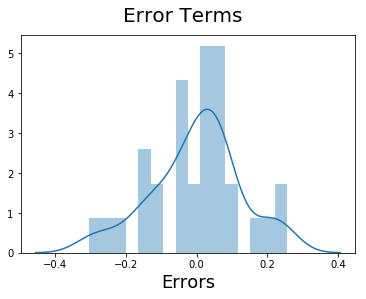

In [1765]:
# Testing Error Rate
y_train_GMV = lr17.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

# Making Predictions Using the Final Model
Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

Applying the scaling on the test sets

In [1766]:
y_test=df_test.pop('GMV')
X_test=df_test

In [1779]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 

X_test_new=X_test[['CameraHousing','ExtensionTube','Digital']]

X_test_new = sm.add_constant(X_test_new)

In [1780]:
# Making predictions
y_pred = lr17.predict(X_test_new)
y_pred

Week
37    0.358484
60    0.359185
64    0.695205
58    0.583176
73    0.474334
79    0.413663
35    0.297347
72    0.416784
50    0.559746
63    0.660761
27    0.287841
43    0.580669
68    0.661760
49    0.358360
75    0.543931
dtype: float64

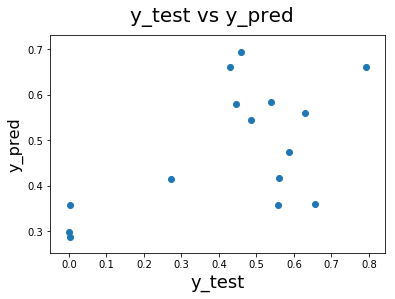

In [1781]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

In [1782]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.27394063511951405

In [1618]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

0.2048011461167469

### Mulitipliative Model for Camera Accessories

In [1619]:
# Creating dataset for building Multiplicative Model and Distributive Lag Model.
WL_camera_MM = WL_camera_M.copy()
WL_camera_DM = WL_camera_M.copy()

In [1620]:
#Assigning least value possible instead of 0, Since log(0) gives infinite.
WL_camera_MM[WL_camera_MM == 0]=0.00001

In [1621]:
#Converting the whole dataframe to logarathmic dataframe
WL_camera_MM_log = np.log(WL_camera_MM)
WL_camera_MM_log.head(5)

,GMV,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,...,OnlineMarketing,OnlineMarketing_Ad_Stock,Other,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock
Week,,,,,,,,,,,,,,,,,,,,,
27,-6.346997,0.000000,0.000000,0.693147,1.386294,0.000000,-11.512925,-11.512925,-11.512925,-11.512925,...,-5.482991,-5.482991,-11.512925,-11.512925,-11.512925,-11.512925,-4.151955,-4.151955,-3.762714,-3.762714
28,-0.954467,5.313206,3.737670,5.802118,6.464588,5.393628,2.397895,-11.512925,-11.512925,-11.512925,...,-1.025709,-1.019929,-11.512925,-11.512925,-11.512925,-11.512925,0.305327,0.311108,0.694568,0.700348
29,-0.796755,5.575949,3.401197,5.860786,6.553933,5.389072,1.791759,-11.512925,-11.512925,-11.512925,...,-0.986728,-0.592208,-11.512925,-11.512925,-11.512925,-11.512925,0.344308,0.738828,0.733548,1.128069
30,-0.836801,5.393628,3.713572,5.673323,6.593045,5.579730,2.197225,-11.512925,-11.512925,-11.512925,...,-1.052305,-0.468909,-11.512925,-11.512925,-11.512925,-11.512925,0.278731,0.862127,0.667972,1.251367
31,-1.236710,5.049856,3.688879,5.236442,6.104793,5.164786,2.197225,-11.512925,-11.512925,-11.512925,...,-1.325912,-0.547485,-11.512925,-11.512925,-11.512925,-11.512925,0.325485,0.943438,0.436606,1.192408


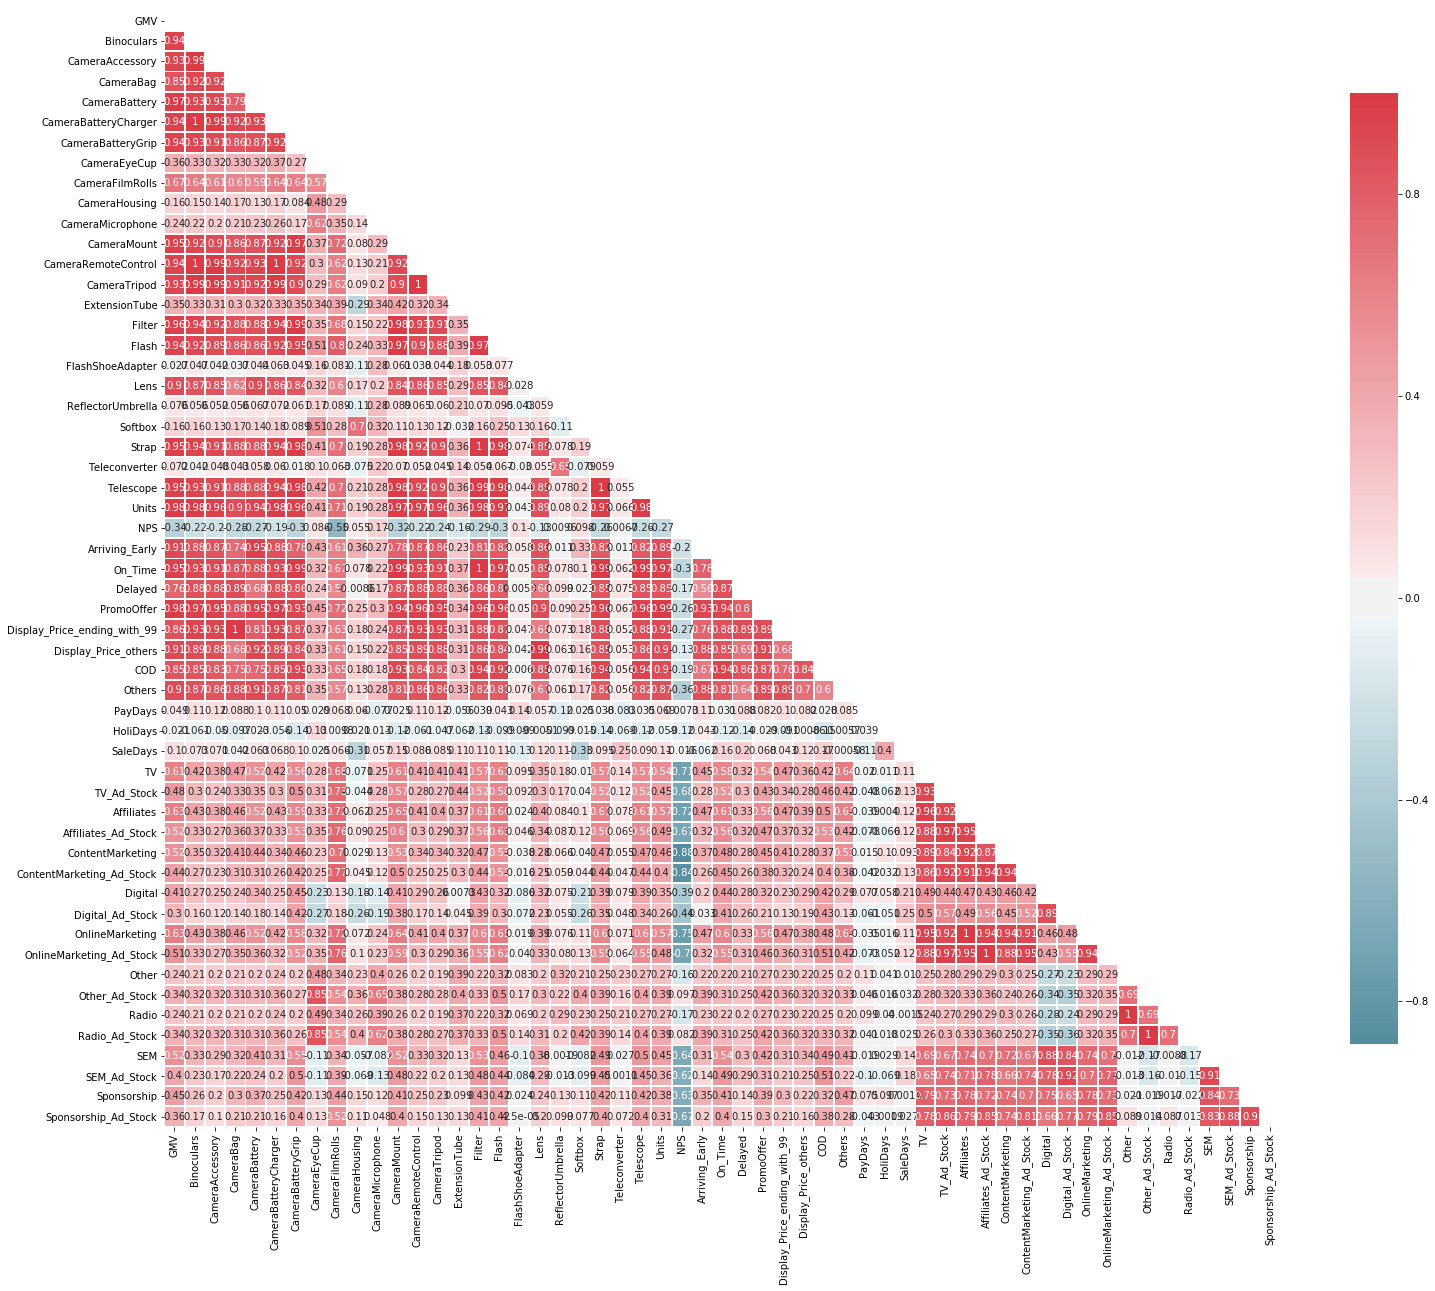

In [1622]:
# Corelation matrix
corr=WL_camera_MM_log.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

In [1886]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(WL_camera_MM_log, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1887]:
# Creating Predicter and influencer variable for Linear Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [1888]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Binoculars', False, 10),
 ('CameraAccessory', False, 4),
 ('CameraBag', True, 1),
 ('CameraBattery', False, 8),
 ('CameraBatteryCharger', False, 9),
 ('CameraBatteryGrip', False, 7),
 ('CameraEyeCup', False, 21),
 ('CameraFilmRolls', False, 22),
 ('CameraHousing', False, 25),
 ('CameraMicrophone', False, 32),
 ('CameraMount', False, 2),
 ('CameraRemoteControl', False, 17),
 ('CameraTripod', True, 1),
 ('ExtensionTube', False, 15),
 ('Filter', False, 19),
 ('Flash', True, 1),
 ('FlashShoeAdapter', False, 33),
 ('Lens', False, 12),
 ('ReflectorUmbrella', False, 35),
 ('Softbox', False, 24),
 ('Strap', True, 1),
 ('Teleconverter', False, 34),
 ('Telescope', False, 5),
 ('Units', True, 1),
 ('NPS', False, 23),
 ('Arriving_Early', True, 1),
 ('On_Time', True, 1),
 ('Delayed', True, 1),
 ('PromoOffer', True, 1),
 ('Display_Price_ending_with_99', True, 1),
 ('Display_Price_others', False, 30),
 ('COD', False, 27),
 ('Others', True, 1),
 ('PayDays', False, 28),
 ('HoliDays', False, 26),
 ('

In [1889]:
# Building simple linear model with log values which gives the Multiplicative Model
#Iteration 1 - CA MM
import statsmodels.api as sm

col = X_train.columns[rfe.support_]
X_train_lm = X_train[col]
X_train_lm = sm.add_constant(X_train_lm)
lm1 = sm.OLS(y_train,X_train_lm).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1501.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.03e-17
Time:                        10:33:29   Log-Likelihood:                 67.159
No. Observations:                  33   AIC:                            -92.32
Df Residuals:                      12   BIC:                            -60.89
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1890]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,16759.35
17,Other_Ad_Stock,14581.61
19,Radio_Ad_Stock,14151.84
18,Radio,6632.95
16,Other,6524.77
5,Units,4203.90
2,CameraTripod,1210.77
9,PromoOffer,994.27
6,Arriving_Early,894.23
10,Display_Price_ending_with_99,724.00


In [1891]:
# Dropping Affilates and creating model.
#Iteration 2 - CA MM
X_train_lm = X_train_lm.drop(['Strap'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm2 = sm.OLS(y_train,X_train_lm).fit() 
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1661.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.77e-19
Time:                        10:33:32   Log-Likelihood:                 66.663
No. Observations:                  33   AIC:                            -93.33
Df Residuals:                      13   BIC:                            -63.40
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1892]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,15256.82
16,Other_Ad_Stock,8942.48
18,Radio_Ad_Stock,8687.37
17,Radio,6251.44
15,Other,6058.15
4,Units,4166.27
8,PromoOffer,734.26
9,Display_Price_ending_with_99,633.95
5,Arriving_Early,623.23
2,CameraTripod,465.26


In [1893]:
X_train_lm = X_train_lm.drop(['
                              Display_Price_ending_with_99'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm3 = sm.OLS(y_train,X_train_lm).fit() 
print(lm3.summary())

SyntaxError: EOL while scanning string literal (<ipython-input-1893-8619de407dd9>, line 1)

In [1894]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,15256.82
16,Other_Ad_Stock,8942.48
18,Radio_Ad_Stock,8687.37
17,Radio,6251.44
15,Other,6058.15
4,Units,4166.27
8,PromoOffer,734.26
9,Display_Price_ending_with_99,633.95
5,Arriving_Early,623.23
2,CameraTripod,465.26


In [1895]:
X_train_lm = X_train_lm.drop(['Radio'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm4 = sm.OLS(y_train,X_train_lm).fit() 
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1732.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.35e-20
Time:                        10:33:37   Log-Likelihood:                 65.241
No. Observations:                  33   AIC:                            -92.48
Df Residuals:                      14   BIC:                            -64.05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1896]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,12434.01
16,Other_Ad_Stock,6959.82
17,Radio_Ad_Stock,6710.02
4,Units,3877.30
8,PromoOffer,647.41
9,Display_Price_ending_with_99,576.38
5,Arriving_Early,430.21
6,On_Time,403.77
3,Flash,319.66
2,CameraTripod,315.91


In [1897]:
X_train_lm = X_train_lm.drop(['ContentMarketing_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm5 = sm.OLS(y_train,X_train_lm).fit() 
print(lm5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1906.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           6.48e-22
Time:                        10:33:41   Log-Likelihood:                 64.733
No. Observations:                  33   AIC:                            -93.47
Df Residuals:                      15   BIC:                            -66.53
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1898]:
X_train_lm = X_train_lm.drop(['Flash'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm6 = sm.OLS(y_train,X_train_lm).fit() 
print(lm6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2033.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.19e-23
Time:                        10:33:42   Log-Likelihood:                 63.739
No. Observations:                  33   AIC:                            -93.48
Df Residuals:                      16   BIC:                            -68.04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1899]:
X_train_lm = X_train_lm.drop(['Other'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm7 = sm.OLS(y_train,X_train_lm).fit() 
print(lm7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2053.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.18e-24
Time:                        10:33:43   Log-Likelihood:                 61.837
No. Observations:                  33   AIC:                            -91.67
Df Residuals:                      17   BIC:                            -67.73
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1900]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,5796.94
14,Radio_Ad_Stock,3406.34
13,Other_Ad_Stock,3364.72
3,Units,2592.76
7,PromoOffer,547.82
8,Display_Price_ending_with_99,481.89
5,On_Time,362.58
4,Arriving_Early,199.10
2,CameraTripod,189.09
9,Others,127.46


In [1901]:
X_train_lm = X_train_lm.drop(['Radio_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm8 = sm.OLS(y_train,X_train_lm).fit() 
print(lm8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1080.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.36e-23
Time:                        10:33:47   Log-Likelihood:                 49.168
No. Observations:                  33   AIC:                            -68.34
Df Residuals:                      18   BIC:                            -45.89
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1902]:
X_train_lm = X_train_lm.drop(['Arriving_Early'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm9 = sm.OLS(y_train,X_train_lm).fit() 
print(lm9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.07e-25
Time:                        10:33:49   Log-Likelihood:                 49.024
No. Observations:                  33   AIC:                            -70.05
Df Residuals:                      19   BIC:                            -49.10
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1903]:
X_train_lm = X_train_lm.drop(['SEM'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm10 = sm.OLS(y_train,X_train_lm).fit() 
print(lm10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1360.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.25e-26
Time:                        10:33:50   Log-Likelihood:                 48.688
No. Observations:                  33   AIC:                            -71.38
Df Residuals:                      20   BIC:                            -51.92
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1904]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,3072.79
3,Units,2042.20
6,PromoOffer,487.91
7,Display_Price_ending_with_99,436.46
4,On_Time,349.49
2,CameraTripod,139.68
1,CameraBag,86.23
5,Delayed,31.70
11,Digital_Ad_Stock,15.91
8,Others,14.97


In [1905]:
X_train_lm = X_train_lm.drop(['Units'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm11 = sm.OLS(y_train,X_train_lm).fit() 
print(lm11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     880.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.17e-25
Time:                        10:33:53   Log-Likelihood:                 39.288
No. Observations:                  33   AIC:                            -54.58
Df Residuals:                      21   BIC:                            -36.62
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1906]:
X_train_lm = X_train_lm.drop(['PromoOffer'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm12 = sm.OLS(y_train,X_train_lm).fit() 
print(lm12.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     966.8
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.12e-26
Time:                        10:33:55   Log-Likelihood:                 38.491
No. Observations:                  33   AIC:                            -54.98
Df Residuals:                      22   BIC:                            -38.52
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1907]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,935.53
3,On_Time,123.71
2,CameraTripod,116.29
5,Display_Price_ending_with_99,109.76
1,CameraBag,61.06
4,Delayed,17.27
6,Others,13.24
9,Digital_Ad_Stock,11.06
10,Other_Ad_Stock,10.23
8,Digital,7.17


In [1908]:
X_train_lm = X_train_lm.drop(['Others'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1115.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.49e-28
Time:                        10:34:00   Log-Likelihood:                 38.371
No. Observations:                  33   AIC:                            -56.74
Df Residuals:                      23   BIC:                            -41.78
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1909]:
X_train_lm = X_train_lm.drop(['const'], axis=1)

# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Display_Price_ending_with_99,1831.38
0,CameraBag,1588.94
1,CameraTripod,494.89
2,On_Time,394.15
3,Delayed,192.71
6,Digital,12.35
7,Digital_Ad_Stock,11.06
8,Other_Ad_Stock,9.89
5,Affiliates_Ad_Stock,3.48


In [1910]:
X_train_lm = X_train_lm.drop(['Delayed'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1279.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.22e-29
Time:                        10:34:08   Log-Likelihood:                 37.994
No. Observations:                  33   AIC:                            -57.99
Df Residuals:                      24   BIC:                            -44.52
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1911]:
X_train_lm = X_train_lm.drop(['Other_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1350.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.33e-30
Time:                        10:34:08   Log-Likelihood:                 36.017
No. Observations:                  33   AIC:                            -56.03
Df Residuals:                      25   BIC:                            -44.06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1912]:
X_train_lm = X_train_lm.drop(['Digital'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm14 = sm.OLS(y_train,X_train_lm).fit() 
print(lm14.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1563.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.76e-32
Time:                        10:34:11   Log-Likelihood:                 35.241
No. Observations:                  33   AIC:                            -56.48
Df Residuals:                      26   BIC:                            -46.01
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1913]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,154.57
2,CameraTripod,63.03
3,On_Time,51.65
4,Display_Price_ending_with_99,35.92
1,CameraBag,33.43
5,Affiliates_Ad_Stock,1.30
6,Digital_Ad_Stock,1.17


In [1914]:
X_train_lm = X_train_lm.drop(['CameraTripod'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm15 = sm.OLS(y_train,X_train_lm).fit() 
print(lm15.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1585.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.97e-32
Time:                        10:34:19   Log-Likelihood:                 31.852
No. Observations:                  33   AIC:                            -51.70
Df Residuals:                      27   BIC:                            -42.72
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1915]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,142.81
1,CameraBag,33.38
3,Display_Price_ending_with_99,33.03
2,On_Time,9.99
4,Affiliates_Ad_Stock,1.30
5,Digital_Ad_Stock,1.16


In [1916]:
X_train_lm = X_train_lm.drop(['Display_Price_ending_with_99'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm16 = sm.OLS(y_train,X_train_lm).fit() 
print(lm16.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2019.
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.17e-34
Time:                        10:34:51   Log-Likelihood:                 31.561
No. Observations:                  33   AIC:                            -53.12
Df Residuals:                      28   BIC:                            -45.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.6480    

In [1943]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,135.40
2,On_Time,9.47
1,CameraBag,9.23
4,Digital_Ad_Stock,1.09
3,Affiliates_Ad_Stock,1.01


In [1944]:
X_train_lm = X_train_lm.drop(['CameraBag'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm17 = sm.OLS(y_train,X_train_lm).fit() 
print(lm17.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     290.4
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.01e-21
Time:                        10:39:43   Log-Likelihood:                -5.2743
No. Observations:                  33   AIC:                             18.55
Df Residuals:                      29   BIC:                             24.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.5766    

In [1945]:
X_train_lm = X_train_lm.drop(['Affiliates_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm18 = sm.OLS(y_train,X_train_lm).fit() 
print(lm18.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     430.6
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           8.07e-23
Time:                        10:40:34   Log-Likelihood:                -5.9985
No. Observations:                  33   AIC:                             18.00
Df Residuals:                      30   BIC:                             22.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.5369      0.104  

Text(0.5,0,'Errors')

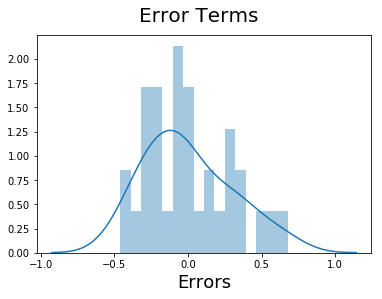

In [1946]:
# Testing Error Rate
y_train_GMV = lm18.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

In [1918]:
y_test=df_test.pop('GMV')
X_test=df_test
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 



In [1950]:
X_test_new=X_test[['On_Time','Digital_Ad_Stock']]

X_test_new = sm.add_constant(X_test_new)
# Making predictions'
y_pred = lm18.predict(X_test_new)
y_pred

Week
37   -9.688959
60   -0.345653
64   -0.667380
58   -0.472981
73   -0.896776
79   -1.372555
35   -9.657794
72   -0.818317
50   -0.498019
63   -0.429644
27   -9.014587
43   -1.173294
68   -0.852636
49   -0.581070
75   -1.144282
dtype: float64

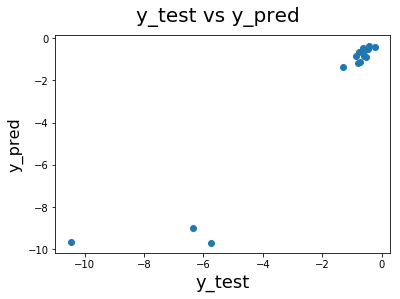

In [1951]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

In [1952]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8113651039526751

# Distributive Model for Camera Accessories

In [1660]:
#Creating Lag Variables for GMV Camera Accessory.
CA_Lag =WL_camera_DM
CA_Lag['GMV_Lag_1'] = WL_camera_DM.GMV.shift(1)
CA_Lag['GMV_Lag_2'] = WL_camera_DM.GMV.shift(2)
CA_Lag['GMV_Lag_3'] = WL_camera_DM.GMV.shift(3)
CA_Lag.head()

,GMV,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,0.001752,1.0,1,2.0,4.0,1.0,0,0,0,0,...,0.0,0.0,0.0,0.015734,0.015734,0.023221,0.023221,NaN,NaN,NaN
28,0.385017,203.0,42,331.0,642.0,220.0,11,0,0,0,...,0.0,0.0,0.0,1.357069,1.364936,2.002843,2.014453,0.001752,NaN,NaN
29,0.450789,264.0,30,351.0,702.0,219.0,6,0,0,0,...,0.0,0.0,0.0,1.411013,2.093481,2.082456,3.089683,0.385017,0.001752,NaN
30,0.433094,220.0,41,291.0,730.0,265.0,9,0,0,0,...,0.0,0.0,0.0,1.321452,2.368193,1.950278,3.495119,0.450789,0.385017,0.001752
31,0.290338,156.0,40,188.0,448.0,175.0,9,0,0,0,...,0.0,0.0,0.0,1.384702,2.568798,1.547447,3.295006,0.433094,0.450789,0.385017


In [1661]:
#Replacing NaN with 0.
CA_Lag.fillna(0)

,GMV,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,0.001752,1.0,1,2.0,4.0,1.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.015734,0.015734,0.023221,0.023221,0.000000,0.000000,0.000000
28,0.385017,203.0,42,331.0,642.0,220.0,11,0,0,0,...,0.000000,0.000000,0.000000,1.357069,1.364936,2.002843,2.014453,0.001752,0.000000,0.000000
29,0.450789,264.0,30,351.0,702.0,219.0,6,0,0,0,...,0.000000,0.000000,0.000000,1.411013,2.093481,2.082456,3.089683,0.385017,0.001752,0.000000
30,0.433094,220.0,41,291.0,730.0,265.0,9,0,0,0,...,0.000000,0.000000,0.000000,1.321452,2.368193,1.950278,3.495119,0.450789,0.385017,0.001752
31,0.290338,156.0,40,188.0,448.0,175.0,9,0,0,0,...,0.000000,0.000000,0.000000,1.384702,2.568798,1.547447,3.295006,0.433094,0.450789,0.385017
35,0.000029,0.0,0,0.0,0.0,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.157096,1.441495,0.066458,1.713961,0.290338,0.433094,0.450789
37,0.003215,0.0,0,0.0,1.0,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,2.480860,3.201607,25.115061,25.972041,0.000029,0.290338,0.433094
39,0.000060,0.0,0,1.0,0.0,0.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.620215,2.221018,6.278765,19.264786,0.003215,0.000029,0.290338
40,0.228163,140.0,23,120.0,324.0,102.0,4,0,12,0,...,0.000000,0.000000,0.000000,4.943681,6.054190,31.646624,41.279017,0.000060,0.003215,0.000029


In [1662]:
#Replacing infinity, NaN, 0's with least value possible 0.00001
CA_Lag =  CA_Lag.replace(-np.inf, 0.00001)
CA_Lag =  CA_Lag.replace(np.nan, 0.00001)
CA_Lag =  CA_Lag.replace(np.zeros, 0.00001)
CA_Lag.columns

Index(['GMV', 'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Teleconverter', 'Telescope', 'Units', 'NPS', 'Arriving_Early',
       'On_Time', 'Delayed', 'PromoOffer', 'Display_Price_ending_with_99',
       'Display_Price_others', 'COD', 'Others', 'PayDays', 'HoliDays',
       'SaleDays', 'TV', 'TV_Ad_Stock', 'Affiliates', 'Affiliates_Ad_Stock',
       'ContentMarketing', 'ContentMarketing_Ad_Stock', 'Digital',
       'Digital_Ad_Stock', 'OnlineMarketing', 'OnlineMarketing_Ad_Stock',
       'Other', 'Other_Ad_Stock', 'Radio', 'Radio_Ad_Stock', 'SEM',
       'SEM_Ad_Stock', 'Sponsorship', 'Sponsorship_Ad_Stock', 'GMV_Lag_1',
       'GMV_Lag_2', 'GMV_Lag_3'],
      d

In [1663]:
## Scaling the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Apply scaler() to all numeric columns except lag variables
num_vars = ['GMV', 'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Teleconverter', 'Telescope', 'Units', 'NPS', 'Arriving_Early',
       'On_Time', 'Delayed', 'PromoOffer', 'Display_Price_ending_with_99',
       'Display_Price_others', 'COD', 'Others', 'PayDays', 'HoliDays',
       'SaleDays', 'TV', 'TV_Ad_Stock', 'Affiliates', 'Affiliates_Ad_Stock',
       'ContentMarketing', 'ContentMarketing_Ad_Stock', 'Digital',
       'Digital_Ad_Stock', 'OnlineMarketing', 'OnlineMarketing_Ad_Stock',
       'Other', 'Other_Ad_Stock', 'Radio', 'Radio_Ad_Stock', 'SEM',
       'SEM_Ad_Stock', 'Sponsorship', 'Sponsorship_Ad_Stock', 'GMV_Lag_1',
       'GMV_Lag_2', 'GMV_Lag_3']
CA_Lag[num_vars] = scaler.fit_transform(CA_Lag[num_vars])
CA_Lag.head()

,GMV,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,-2.149146,-1.936943,-2.263453,-2.022448,-2.066345,-1.819658,-1.521574,-0.729558,-1.304823,-0.425812,...,-0.646573,-0.539482,-0.663298,-0.784979,-1.071872,-0.945945,-1.297621,-2.054012,-1.939262,-1.827965
28,-0.452819,-0.372154,0.742266,0.169173,0.033531,-0.333507,1.165353,-0.729558,-1.304823,-0.425812,...,-0.646573,-0.539482,-0.663298,-0.210245,-0.676019,-0.694285,-1.122246,-2.046584,-1.939262,-1.827965
29,-0.161712,0.100381,-0.137457,0.302403,0.231011,-0.340294,-0.055978,-0.729558,-1.304823,-0.425812,...,-0.646573,-0.539482,-0.663298,-0.187131,-0.462265,-0.684164,-1.027547,-0.412193,-1.932126,-1.827965
30,-0.240033,-0.240464,0.668956,-0.097285,0.323169,-0.028134,0.676821,-0.729558,-1.304823,-0.425812,...,-0.646573,-0.539482,-0.663298,-0.225506,-0.381665,-0.700967,-0.991839,-0.131716,-0.362212,-1.821087
31,-0.871869,-0.736238,0.595646,-0.783416,-0.604990,-0.638881,0.676821,-0.729558,-1.304823,-0.425812,...,-0.646573,-0.539482,-0.663298,-0.198405,-0.322808,-0.752177,-1.009464,-0.207177,-0.092799,-0.307770


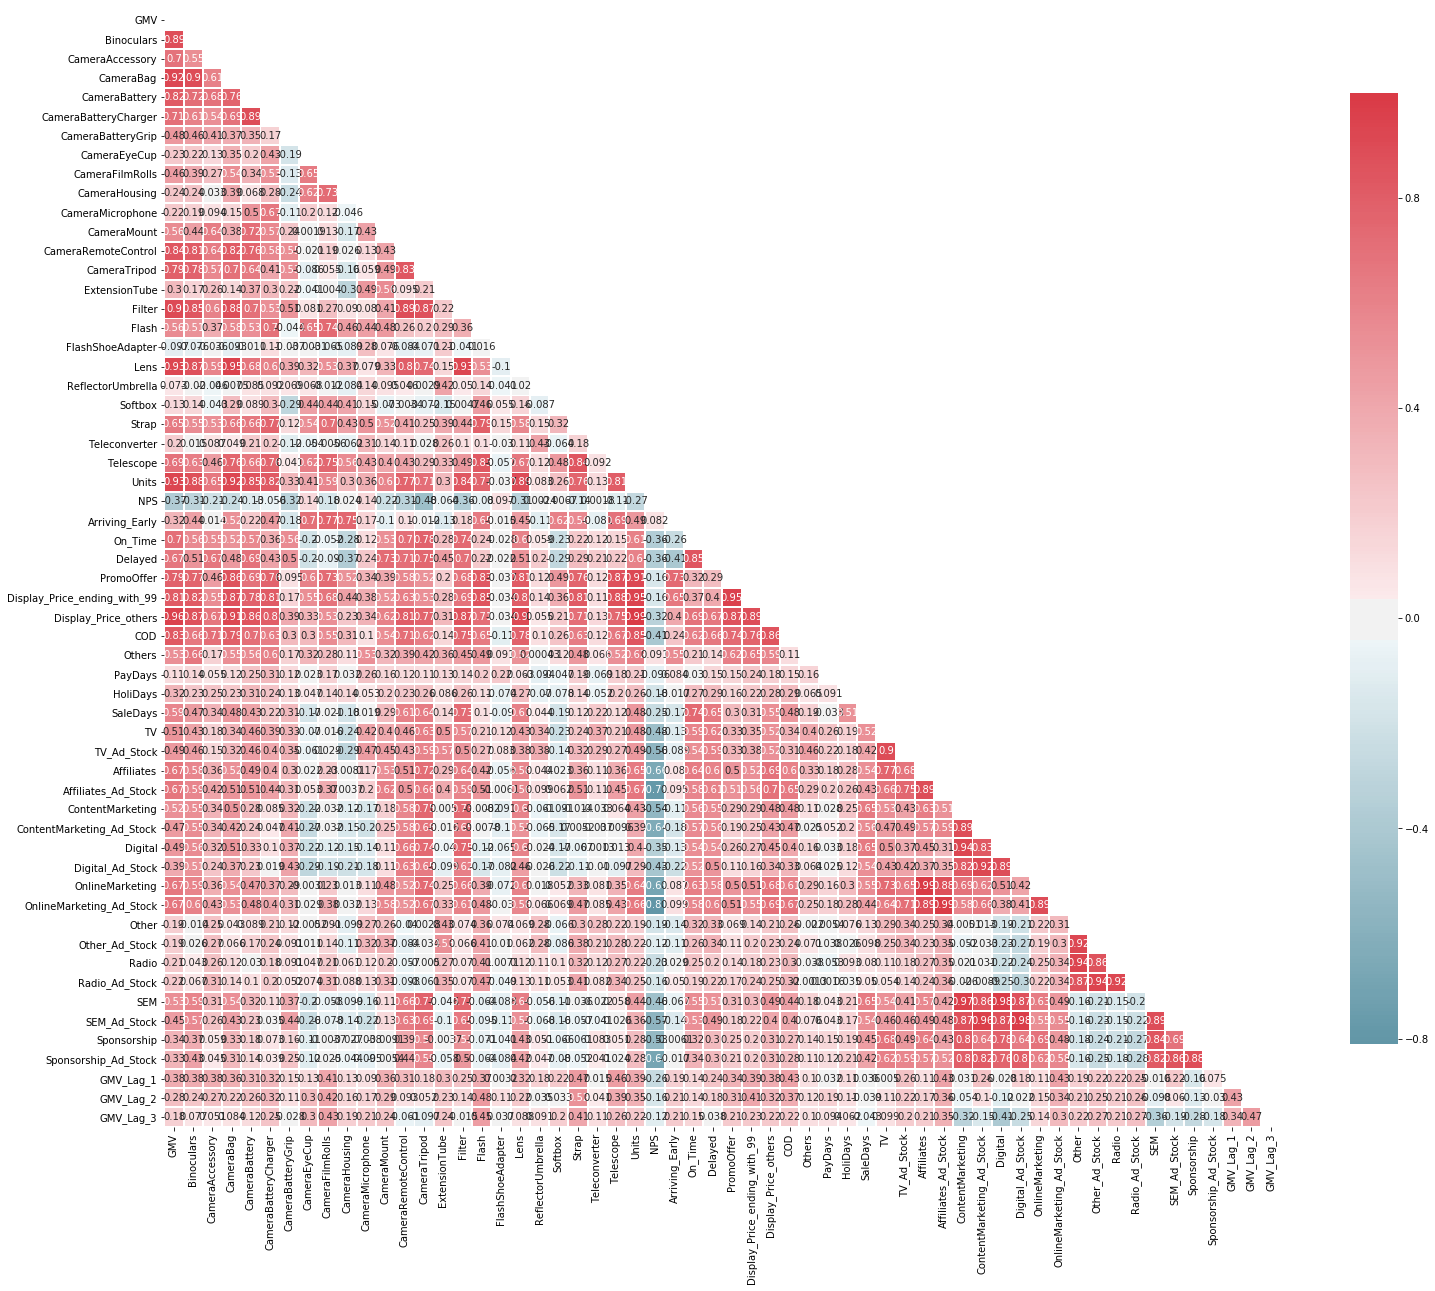

In [1664]:
# Corelation matrix
corr=CA_Lag.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})
#plt.figure(figsize = (16, 10))
#sns.heatmap(df_CA_Lag.corr(), annot = True, cmap="YlGnBu")
#plt.show()

In [1687]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(CA_Lag, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1688]:
# Creating Predicter and influencer variable for Lenier Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [1689]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Binoculars', False, 28),
 ('CameraAccessory', False, 6),
 ('CameraBag', True, 1),
 ('CameraBattery', False, 11),
 ('CameraBatteryCharger', False, 41),
 ('CameraBatteryGrip', False, 16),
 ('CameraEyeCup', False, 14),
 ('CameraFilmRolls', False, 2),
 ('CameraHousing', False, 10),
 ('CameraMicrophone', False, 23),
 ('CameraMount', False, 37),
 ('CameraRemoteControl', False, 13),
 ('CameraTripod', False, 33),
 ('ExtensionTube', True, 1),
 ('Filter', False, 9),
 ('Flash', False, 36),
 ('FlashShoeAdapter', False, 15),
 ('Lens', False, 19),
 ('ReflectorUmbrella', False, 43),
 ('Softbox', False, 20),
 ('Strap', False, 8),
 ('Teleconverter', False, 42),
 ('Telescope', False, 4),
 ('Units', True, 1),
 ('NPS', False, 24),
 ('Arriving_Early', True, 1),
 ('On_Time', True, 1),
 ('Delayed', True, 1),
 ('PromoOffer', False, 22),
 ('Display_Price_ending_with_99', True, 1),
 ('Display_Price_others', False, 21),
 ('COD', True, 1),
 ('Others', True, 1),
 ('PayDays', False, 35),
 ('HoliDays', False, 5),

In [1690]:
#Building Linear Regression Model with Lag Variable which gives Distributive Lag Model
#Iteration 1 - CA DL Model
col = X_train.columns[rfe.support_]
import statsmodels.api as sm

X_train_lm = X_train[col]
X_train_lm = sm.add_constant(X_train_lm)
dl = sm.OLS(y_train,X_train_lm).fit()
print(dl.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     79.15
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.13e-13
Time:                        10:08:41   Log-Likelihood:                 23.323
No. Observations:                  33   AIC:                            -16.65
Df Residuals:                      18   BIC:                             5.801
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1691]:
X_train_lm = X_train_lm.drop(['const'], axis=1)
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Arriving_Early,inf
4,On_Time,inf
5,Delayed,inf
7,COD,inf
8,Others,inf
2,Units,2.651421e+04
12,Other_Ad_Stock,3.519800e+02
13,Radio_Ad_Stock,3.093000e+02
6,Display_Price_ending_with_99,6.498000e+01
14,SEM_Ad_Stock,4.769000e+01


In [1692]:
X_train_lm = X_train_lm.drop(['Other_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl1 = sm.OLS(y_train,X_train_lm).fit() 
print(dl1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     89.50
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.35e-14
Time:                        10:08:44   Log-Likelihood:                 23.238
No. Observations:                  33   AIC:                            -18.48
Df Residuals:                      19   BIC:                             2.475
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1693]:
X_train_lm = X_train_lm.drop(['Radio_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl2 = sm.OLS(y_train,X_train_lm).fit() 
print(dl2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     93.51
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.51e-15
Time:                        10:08:44   Log-Likelihood:                 21.818
No. Observations:                  33   AIC:                            -17.64
Df Residuals:                      20   BIC:                             1.818
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1694]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Arriving_Early,inf
5,On_Time,inf
6,Delayed,inf
8,COD,inf
9,Others,inf
3,Units,2.601183e+04
7,Display_Price_ending_with_99,4.504000e+01
13,SEM_Ad_Stock,1.392000e+01
1,CameraBag,1.349000e+01
11,Digital,1.093000e+01


In [1695]:
X_train_lm = X_train_lm.drop(['Others'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl3 = sm.OLS(y_train,X_train_lm).fit() 
print(dl3.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     93.51
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.51e-15
Time:                        10:08:46   Log-Likelihood:                 21.818
No. Observations:                  33   AIC:                            -17.64
Df Residuals:                      20   BIC:                             1.818
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1696]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Units,26011.83
4,Arriving_Early,21668.17
6,Delayed,19060.37
5,On_Time,204.72
7,Display_Price_ending_with_99,45.04
12,SEM_Ad_Stock,13.92
1,CameraBag,13.49
10,Digital,10.93
8,COD,7.21
11,OnlineMarketing,6.08


In [1697]:
X_train_lm = X_train_lm.drop(['Delayed'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl4 = sm.OLS(y_train,X_train_lm).fit() 
print(dl4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     81.63
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.12e-14
Time:                        10:08:50   Log-Likelihood:                 17.427
No. Observations:                  33   AIC:                            -10.85
Df Residuals:                      21   BIC:                             7.105
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1698]:
X_train_lm = X_train_lm.drop(['Arriving_Early'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl5 = sm.OLS(y_train,X_train_lm).fit() 
print(dl5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     94.05
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.12e-15
Time:                        10:08:50   Log-Likelihood:                 17.422
No. Observations:                  33   AIC:                            -12.84
Df Residuals:                      22   BIC:                             3.617
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1699]:
X_train_lm = X_train_lm.drop(['On_Time'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl6 = sm.OLS(y_train,X_train_lm).fit() 
print(dl6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     107.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.23e-16
Time:                        10:08:50   Log-Likelihood:                 17.158
No. Observations:                  33   AIC:                            -14.32
Df Residuals:                      23   BIC:                            0.6501
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1700]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Units,43.82
4,Display_Price_ending_with_99,14.58
1,CameraBag,11.75
9,SEM_Ad_Stock,10.95
7,Digital,8.27
5,COD,5.51
6,TV_Ad_Stock,5.04
8,OnlineMarketing,4.09
2,ExtensionTube,2.03
0,const,1.06


In [1701]:
X_train_lm = X_train_lm.drop(['Units'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl7 = sm.OLS(y_train,X_train_lm).fit() 
print(dl7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     59.18
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           6.31e-14
Time:                        10:08:51   Log-Likelihood:                 5.0968
No. Observations:                  33   AIC:                             7.806
Df Residuals:                      24   BIC:                             21.28
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1702]:
X_train_lm = X_train_lm.drop(['TV_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl8 = sm.OLS(y_train,X_train_lm).fit() 
print(dl8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     69.36
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           8.62e-15
Time:                        10:08:52   Log-Likelihood:                 4.8507
No. Observations:                  33   AIC:                             6.299
Df Residuals:                      25   BIC:                             18.27
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1703]:
X_train_lm = X_train_lm.drop(['COD'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl9 = sm.OLS(y_train,X_train_lm).fit() 
print(dl9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     82.39
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.16e-15
Time:                        10:08:53   Log-Likelihood:                 4.5170
No. Observations:                  33   AIC:                             4.966
Df Residuals:                      26   BIC:                             15.44
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [1704]:
X_train_lm = X_train_lm.drop(['Display_Price_ending_with_99'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl10 = sm.OLS(y_train,X_train_lm).fit() 
print(dl10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     96.22
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.45e-16
Time:                        10:08:54   Log-Likelihood:                 3.5026
No. Observations:                  33   AIC:                             4.995
Df Residuals:                      27   BIC:                             13.97
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0094      0.042     

In [1705]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,SEM_Ad_Stock,8.36
3,Digital,6.91
4,OnlineMarketing,2.81
1,CameraBag,1.84
2,ExtensionTube,1.42
0,const,1.02


In [1716]:
X_train_lm = X_train_lm.drop(['OnlineMarketing'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl11 = sm.OLS(y_train,X_train_lm).fit() 
print(dl11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     108.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.27e-16
Time:                        10:16:33   Log-Likelihood:                 1.3398
No. Observations:                  33   AIC:                             7.320
Df Residuals:                      28   BIC:                             14.80
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0070      0.044      0.157

Text(0.5,0,'Errors')

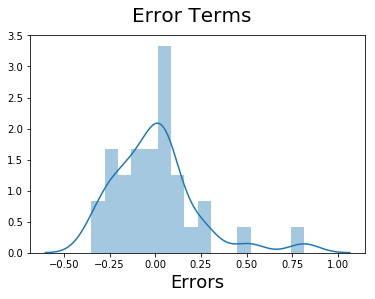

In [1717]:
# Testing Error Rate
y_train_GMV = dl11.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [1708]:
y_test=df_test.pop('GMV')
X_test=df_test

In [1730]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 

X_test_new=X_test[['CameraBag','Digital','SEM_Ad_Stock','ExtensionTube']]

X_test_new = sm.add_constant(X_test_new)
y_pred = dl11.predict(X_test_new)
y_pred

Week
37   -2.072859
60   -0.187785
64    0.954132
58    0.828092
73    0.568907
79   -0.870443
35   -2.034441
72    0.433901
50    0.204589
63    1.128618
27   -1.917942
43   -0.840106
68    0.919449
49   -0.505595
75    0.147105
dtype: float64

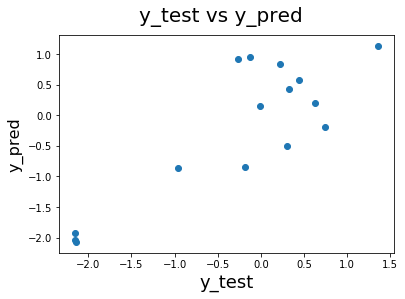

In [1731]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

In [1732]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6938468046773545